# Traffic in a Post-Lockdown World

This project is adapted from Data 100 Final Project, exploring the traffic data provided by the [Uber Movement](https://movement.uber.com/) dataset, specifically in March 2020 when the COVID shutdown began.

In [1]:
%matplotlib inline

import gzip
import re
import urllib.request
import warnings
from typing import Callable
from zipfile import ZipFile

import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import HTML, Javascript, display
from matplotlib import pyplot as plt

from trafficFunc import plotChoro, plotDist, trainTS, performance, ts_to_ds


warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 8
plt.rcParams['figure.titlesize'] = 10
plt.rcParams['axes.linewidth'] = 0.1
plt.rcParams['patch.linewidth'] = 0

display(HTML("<style>.container { width:100% !important; }</style>"))

## Resources:

-  [Uber Traffic Speeds](https://movement.uber.com/explore/san_francisco/speeds/query?dt[tpb]=ALL_DAY&dt[wd;]=1,2,3,4,5,6,7&dt[dr][sd]=2020-03-01&dt[dr][ed]=2020-03-31&ff=&lat.=37.7749295&lng.=-122.4370966&z.=13&lang=en-US)

- [Census Tracts Geojson](https://movement.uber.com/explore/san_francisco/travel-times/query?si=1277&ti=&ag=censustracts&dt[tpb]=ALL_DAY&dt[wd;]=1,2,3,4,5,6,7&dt[dr][sd]=2020-03-01&dt[dr][ed]=2020-03-31&cd=&sa;=&sdn=&lat.=37.7749295&lng.=-122.4547777&z.=12&lang=en-US)\
Download Data -> Geo Boundaries\
IDs assigned according to the US 2010 Census; Uber Movement uses these IDs to identify regions of differing travel times

- [Travel Times](https://movement.uber.com/explore/san_francisco/travel-times/query?si=1277&ti=&ag=censustracts&dt[tpb]=ALL_DAY&dt[wd;]=1,2,3,4,5,6,7&dt[dr][sd]=2020-03-01&dt[dr][ed]=2020-03-31&cd=&sa;=&sdn=&lang=en-US)

- [OpenStreetMap XML gzip](https://download.bbbike.org/osm/bbbike/SanFrancisco/)\
IDs provided by [nodes](https://wiki.openstreetmap.org/wiki/Node)
 and [ways](https://wiki.openstreetmap.org/wiki/Way); Uber Movement uses these IDs to identify streets in the traffic speeds dataset

- [Google Plus Codes](https://maps.google.com/pluscodes/) divide up the world uniformly into rectangular slices (spatial partitioning)

- [traffic.py](https://github.com/eugpoon/projects/blob/master/trafficFunc.py)

## Load and Clean Data

In [2]:
# # redownload speed csv from link
# speed = df_shrink(pd.read_csv('data/movement-speeds-hourly-san-francisco-2020-3.csv.zip', compression='zip'))
# speed = speed[['day', 'osm_start_node_id', 'osm_end_node_id', 'speed_mph_mean']]
# speed = speed.groupby(['day', 'osm_start_node_id',
#                        'osm_end_node_id']).mean().reset_index()
# speed.to_pickle('data/movement-speeds-daily-san-francisco-2020-3.pkl')
# !rm "data/movement-speeds-hourly-san-francisco-2020-3.csv.zip"

files = ZipFile('data/traffic.zip')
print(np.sort(files.namelist()))

['__MACOSX/._san_francisco_censustracts.json'
 '__MACOSX/._travel-times-daily-san-francisco-2020-3.csv'
 'movement-speeds-daily-san-francisco-2020-3.pkl'
 'san_francisco_censustracts.json'
 'travel-times-daily-san-francisco-2020-3.csv']


In [3]:
# daily traffic speed
speed = pd.read_pickle(files.open(
    'movement-speeds-daily-san-francisco-2020-3.pkl'))
# census tracts
bound = gpd.read_file(files.open('san_francisco_censustracts.json'))
bound['MOVEMENT_ID'] = bound['MOVEMENT_ID'].astype(int)
# daily travel time
times = pd.read_csv(files.open('travel-times-daily-san-francisco-2020-3.csv'))
times = (times[['Destination Movement ID', 'day',
               'Mean Travel Time (Seconds)', 'Destination Display Name']]
         .rename(columns={'Destination Movement ID': 'destID',
                          'Mean Travel Time (Seconds)': 'time',
                          'Destination Display Name': 'destName'})
         )
times['time'] = np.round(times['time']/60, 4)
# OpenStreetMap XML


def read_node_lat_lon(path: str, pattern: str, line_condition: Callable):
    '''
    Read the provided path line at a line. If the provided regex pattern
    has a match, return the grouped matches as items in a generator.

    :param path: Path to read data from
    :param pattern: Regex pattern to test against each line
    :param line_condition: function that returns if we should check regex
        against current line
    '''
    with gzip.open(path) as f:
        for line in f:
            result = re.search(pattern, line.decode('utf-8'))
            if result is not None and line_condition(result):
                yield int(result.group(1)), float(result.group(2)), float(result.group(3))


filename = 'https://download.bbbike.org/osm/bbbike/SanFrancisco/SanFrancisco.osm.gz'
urllib.request.urlretrieve(filename, 'SanFrancisco.osm.gz')

nodeID = set(speed.osm_start_node_id) | set(speed.osm_end_node_id)
pattern = r"id=\"(\d+)\"\s+lat=\"(\-*\d+\.*\d*)\"\s+lon=\"(\-*\d+\.*\d*)"

node = pd.DataFrame(read_node_lat_lon('SanFrancisco.osm.gz',
                                      pattern=pattern,
                                      line_condition=lambda result: int(
                                          result.group(1)) in nodeID
                                      ), columns=['osm_node_id', 'Latitude', 'Longitude'])
!rm SanFrancisco.osm.gz

In [4]:
display(speed.head(2))
display(bound.head(2))
display(times.head(2))
display(node.head(2))

day  osm_start_node_id  osm_end_node_id  speed_mph_mean
0    1             281266        702258940       59.674042
1    1             281266        702274215       68.444046

MOVEMENT_ID                                       DISPLAY_NAME  \
0            1                            Sargent Creek, San Ardo   
1            2  400 Northumberland Avenue, Redwood Oaks, Redwo...   

                                            geometry  
0  MULTIPOLYGON (((-121.59511 36.11126, -121.5401...  
1  MULTIPOLYGON (((-122.22463 37.46507, -122.2236...

destID  day    time                                          destName
0       9    1  5.3667        500 Hyde Street, Tenderloin, San Francisco
1      20    1  4.8500  900 Sutter Street, Lower Nob Hill, San Francisco

osm_node_id   Latitude   Longitude
0     26118026  37.675280 -122.389194
1     29891973  37.674935 -122.389130

## Exploratory Data Analysis
### Traffic Speed

Plus Code: differences between subpopulations (10.173) outweigh the differences within subpopulations (8.676), so plus codes may not be the most meaningful subdivider of populations as they don’t take into account demographic or traffic conditions (only uniform division by size)

Census Tract: differences between (8.343) and within (8.316) subpopulations do not differ too much, census tracts are not a very effective way of creating meaningful spatial subpopulations.

In [5]:
# map speed to gps coordinates
speedGPS = speed.merge(node, left_on='osm_start_node_id',
                       right_on='osm_node_id')

speedGPS = (gpd.GeoDataFrame(speedGPS,
                             geometry=gpd.points_from_xy(speedGPS.Longitude, speedGPS.Latitude))
            .set_crs('epsg:4326').sjoin(bound))

# convert gps coordinates to plus code regions; assume regions are 0.012 degrees
speedGPS['plus_lat'] = (speedGPS.Latitude // 0.012).astype(int)
speedGPS['plus_lon'] = (speedGPS.Longitude // 0.012).astype(int)

speedPC = speedGPS.groupby(['plus_lat', 'plus_lon'])
print('Plus Code')
print('# of regions: ', len(speedGPS.groupby(['plus_lat', 'plus_lon'])))
print(
    f"Average of SD: {speedPC.std(numeric_only=True).speed_mph_mean.mean():.3f}")
print(
    f"SD of average: {speedPC.mean(numeric_only=True).speed_mph_mean.std():.3f}\n")
# display(speedGPS.head(2))

speedCT = speedGPS.groupby('MOVEMENT_ID')
print('Census Tract')
print('# of tracts:', len(speedGPS.groupby('MOVEMENT_ID')))
print(
    f"Average of SD: {speedCT.std(numeric_only=True).speed_mph_mean.mean():.3f}")
print(
    f"SD of average: {speedCT.mean(numeric_only=True).speed_mph_mean.std():.3f}")
# display(speedGPS.head(2))

Plus Code
# of regions:  276
Average of SD: 8.676
SD of average: 10.172

Census Tract
# of tracts: 295
Average of SD: 8.315
SD of average: 8.341


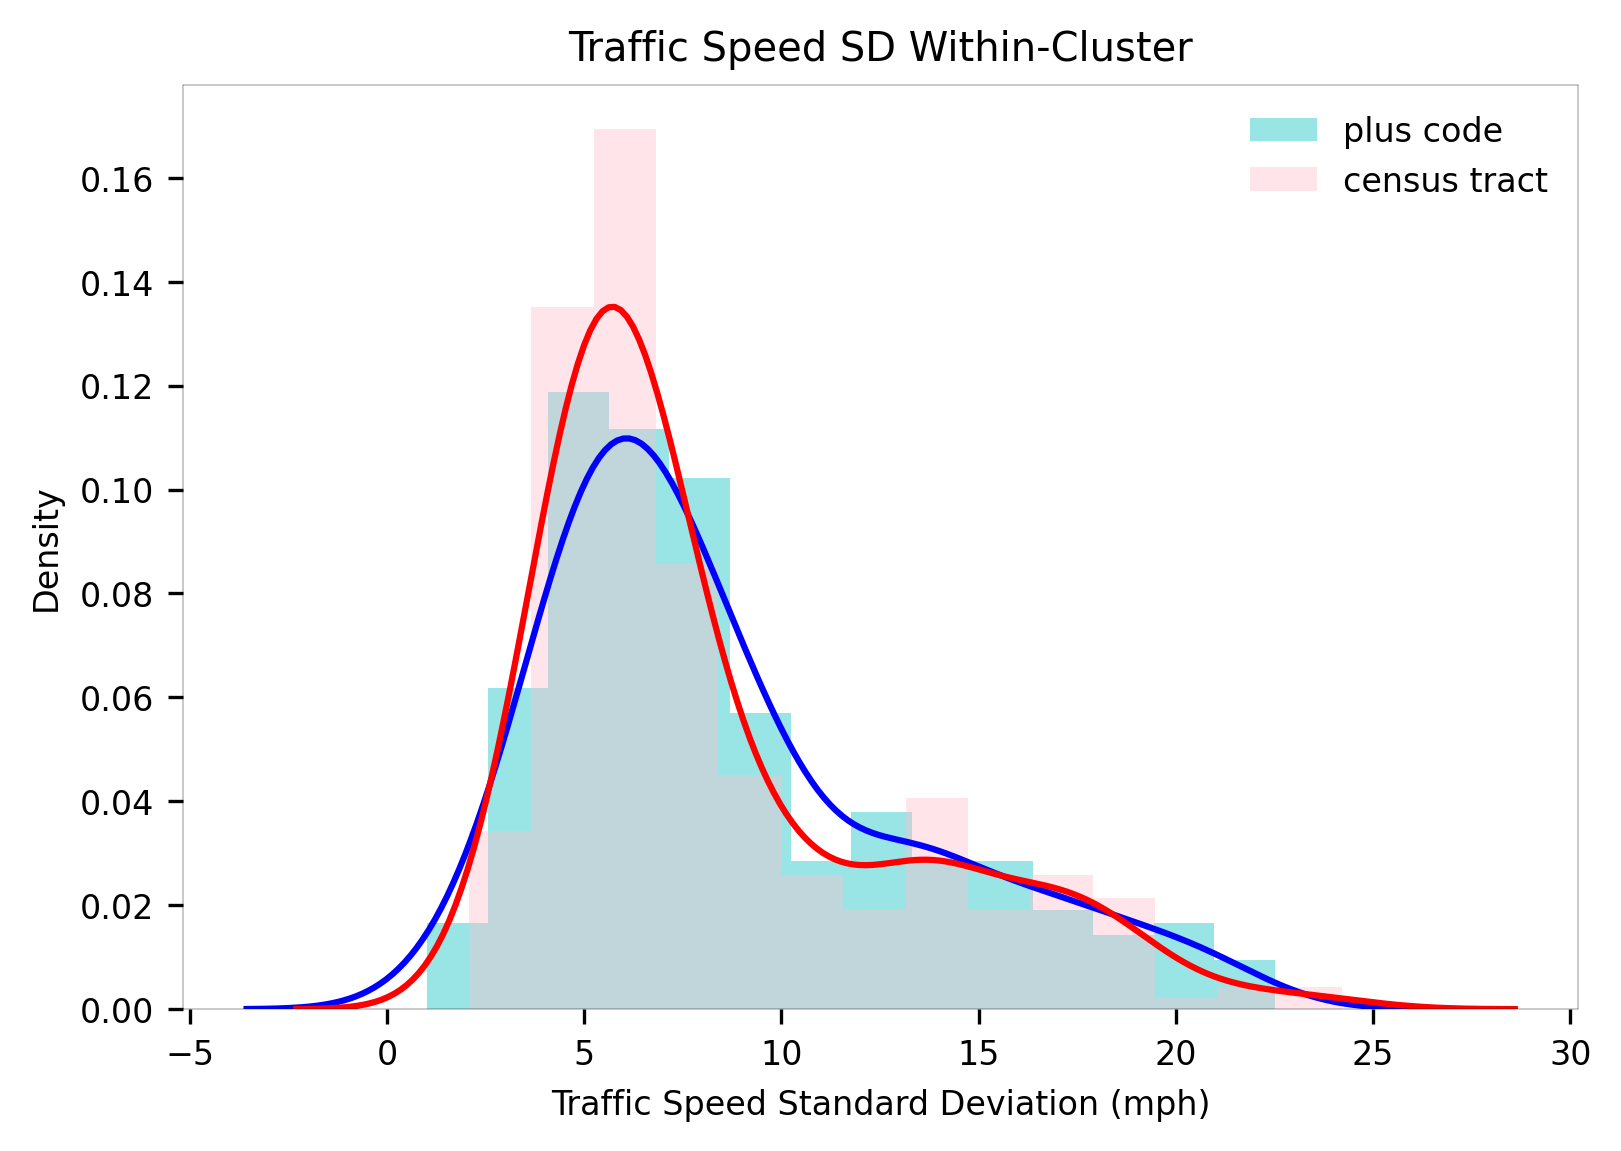

In [6]:
sns.distplot(speedPC.std(numeric_only=True).speed_mph_mean, color='c',
             hist_kws={'linewidth': 0, 'alpha': 0.4},
             kde_kws={'color': 'blue'}, label='plus code')

sns.distplot(speedCT.std(numeric_only=True).speed_mph_mean, color='pink',
             hist_kws={'linewidth': 0, 'alpha': 0.4},
             kde_kws={'color': 'red'}, label='census tract')

plt.title('Traffic Speed SD Within-Cluster')
plt.xlabel('Traffic Speed Standard Deviation (mph)')
plt.legend()
plt.show()

#### Pre vs Post Lockdown

Post lockdown average speeds skew higher. People can drive faster with fewer cars on the road as people stay home and have less reason to commute.

##### Spatial Analysis

**Pre-Lockdown:** slow within center of SF $\rightarrow$ SF is densely populated and has narrow, complicated streets ans steep hills; faster as you move away from SF

**Difference:** SF had little impact due to the unchangeable characteristics of the city; larger differnce away from SF

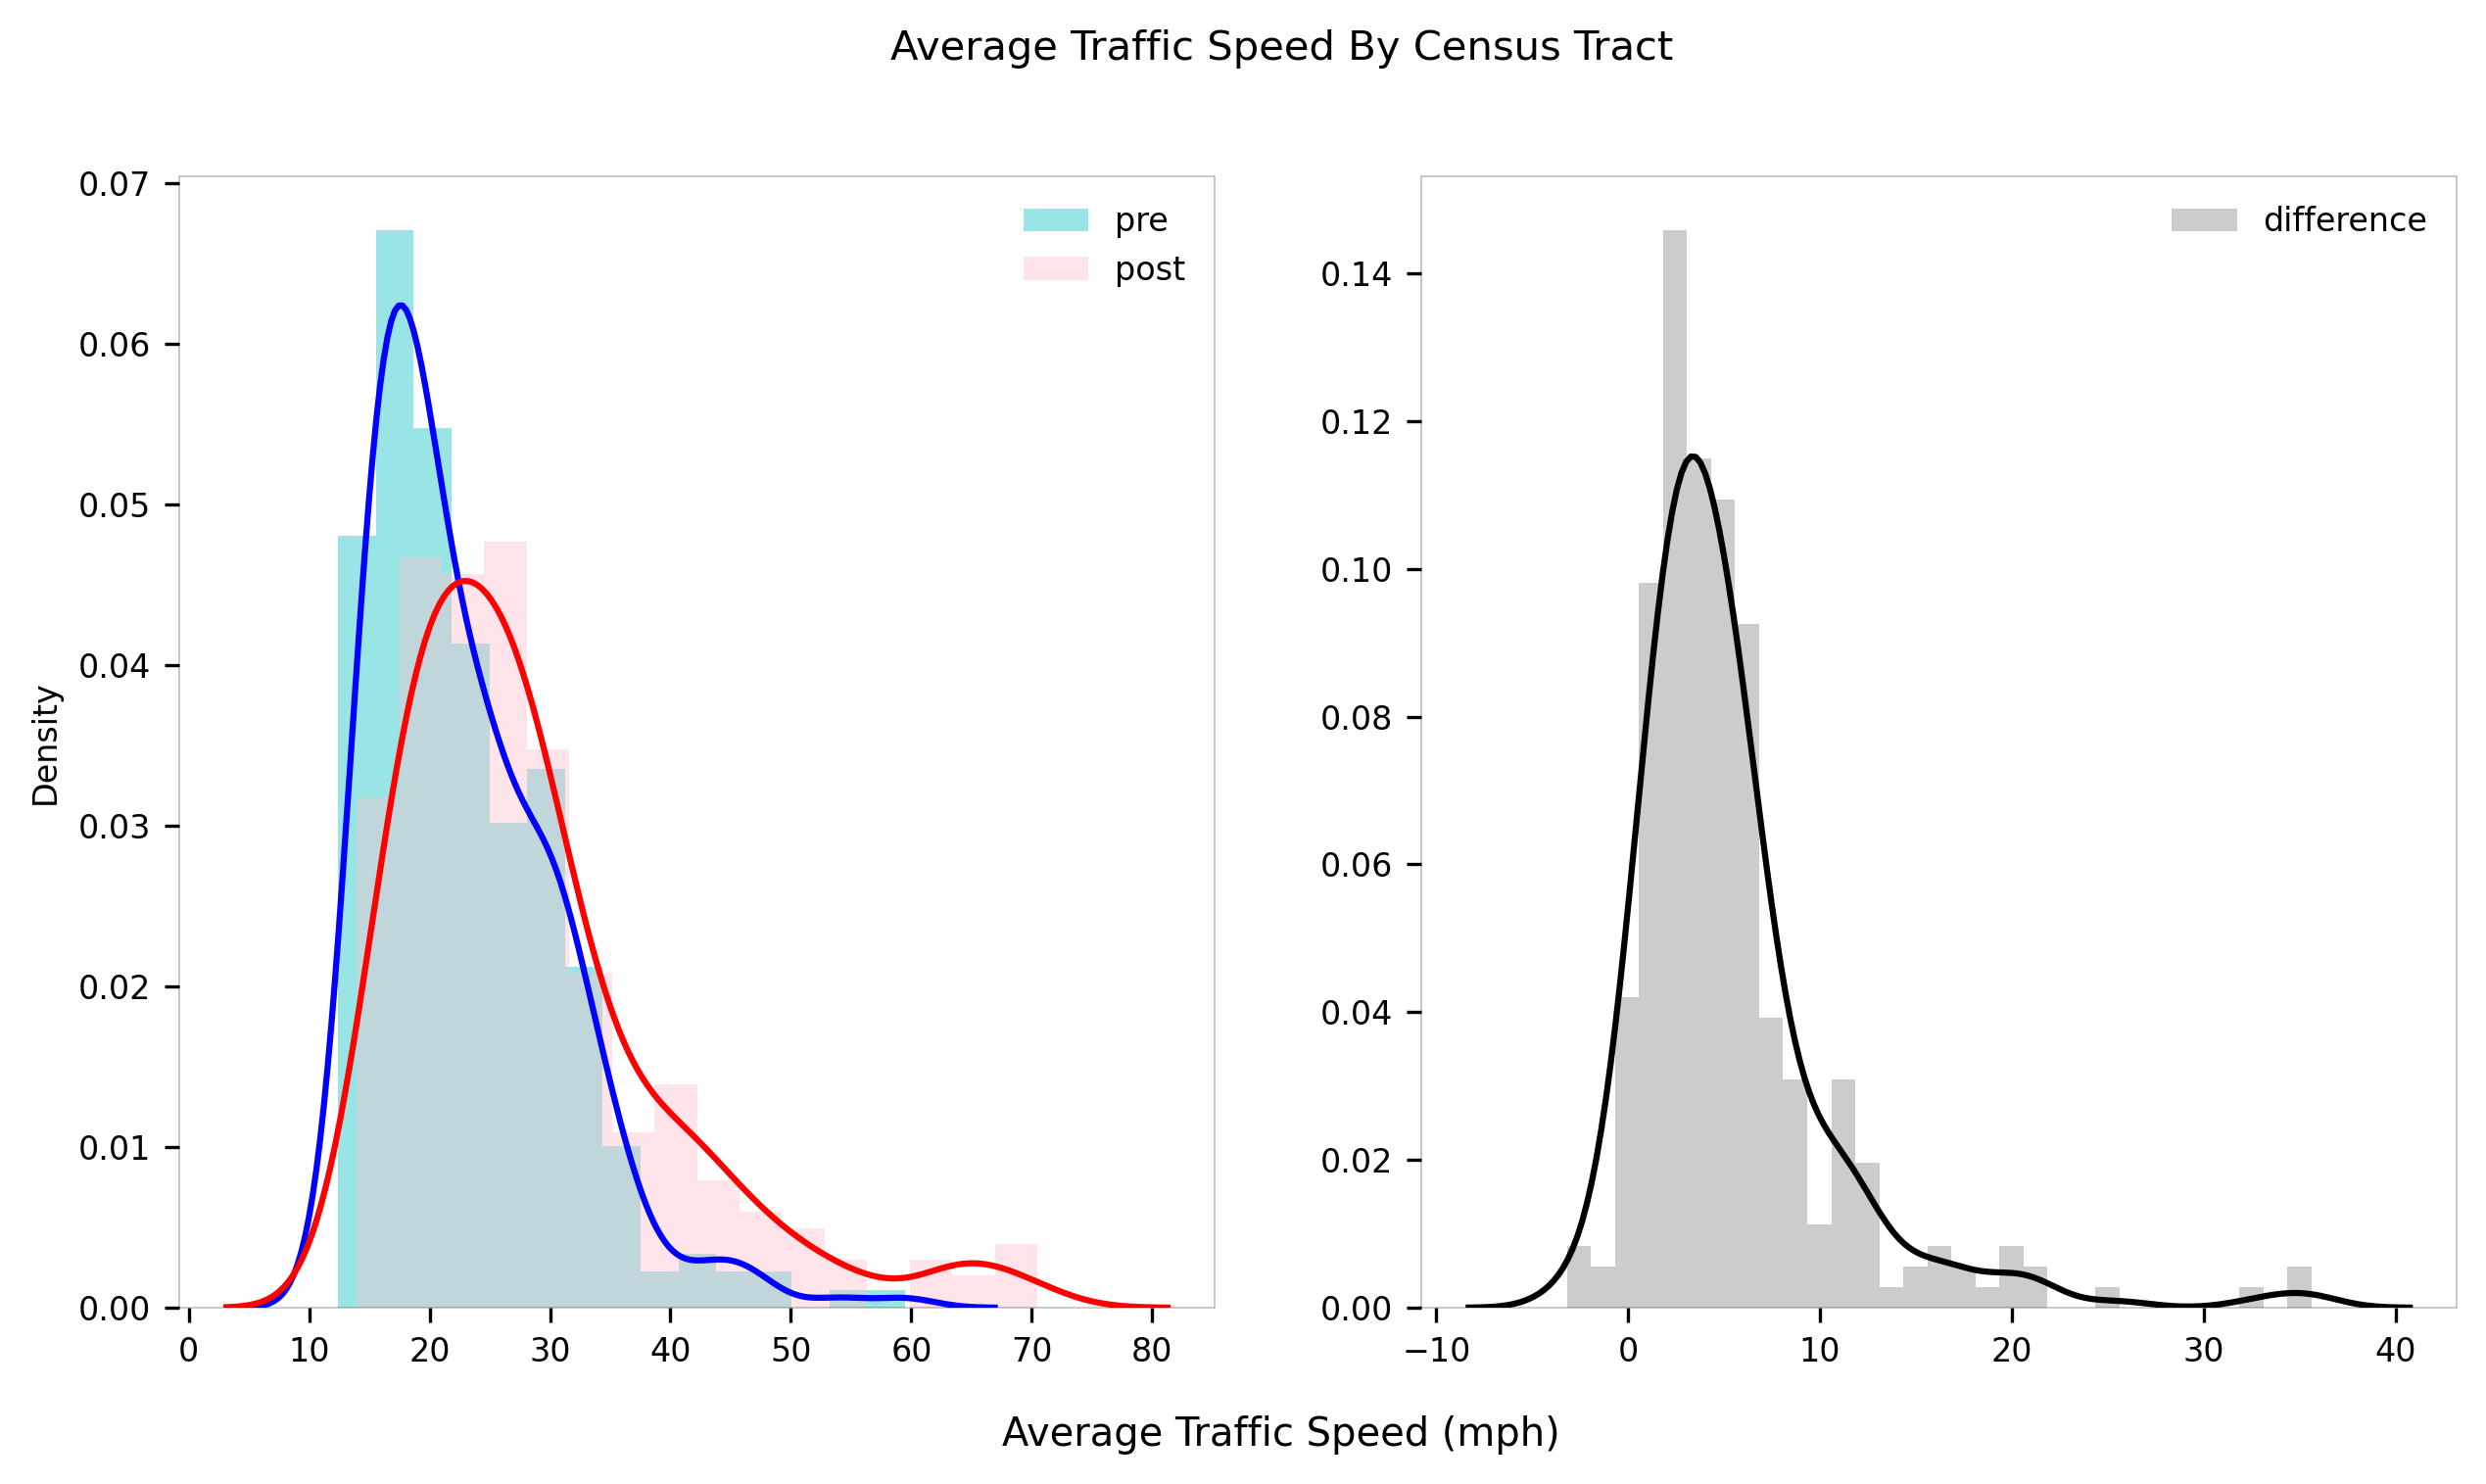

In [7]:
# pre-lockdown:  March 1  - 13, 2020
speedPRE = (speedGPS[speedGPS.day < 14]
            .groupby('MOVEMENT_ID', as_index=False).mean(numeric_only=True)
            .merge(bound)[['MOVEMENT_ID', 'geometry', 'speed_mph_mean']])
# post-lockdown: March 14 - 31, 2020
speedPOS = (speedGPS[speedGPS.day >= 14]
            .groupby('MOVEMENT_ID', as_index=False).mean(numeric_only=True)
            .merge(bound)[['MOVEMENT_ID', 'geometry', 'speed_mph_mean']])
# difference
pre_post = (speedPRE.merge(speedPOS, on='MOVEMENT_ID')
            .rename(columns={'speed_mph_mean_x': 'speedPRE',
                             'speed_mph_mean_y': 'speedPOS',
                             'geometry_x': 'geometry'})
            .drop(columns=['geometry_y']))
pre_post['change'] = pre_post.speedPOS - pre_post.speedPRE
pre_post = gpd.GeoDataFrame(pre_post).set_index('MOVEMENT_ID')

del speedPRE, speedPOS

plotDist(df=pre_post, col=['speedPRE', 'speedPOS'],
         title='Average Traffic Speed By Census Tract',
         x='Average Traffic Speed (mph)')

plotChoro(df=pre_post, col=['speedPRE',
          'speedPOS', 'change'], var='Speed (mph)')

<a id='speeds_daily'></a>
#### Average Traffic Speed by Day

Sharp increase between the 16th and 17th. After implementing shelter-in-place on the 16th, nearly 7 million residents had to restrict activities, leading to fewer people on the road (ABC news).  With fewer people, there was less traffic, and people could drive faster, which resulted in the jump in average speed.

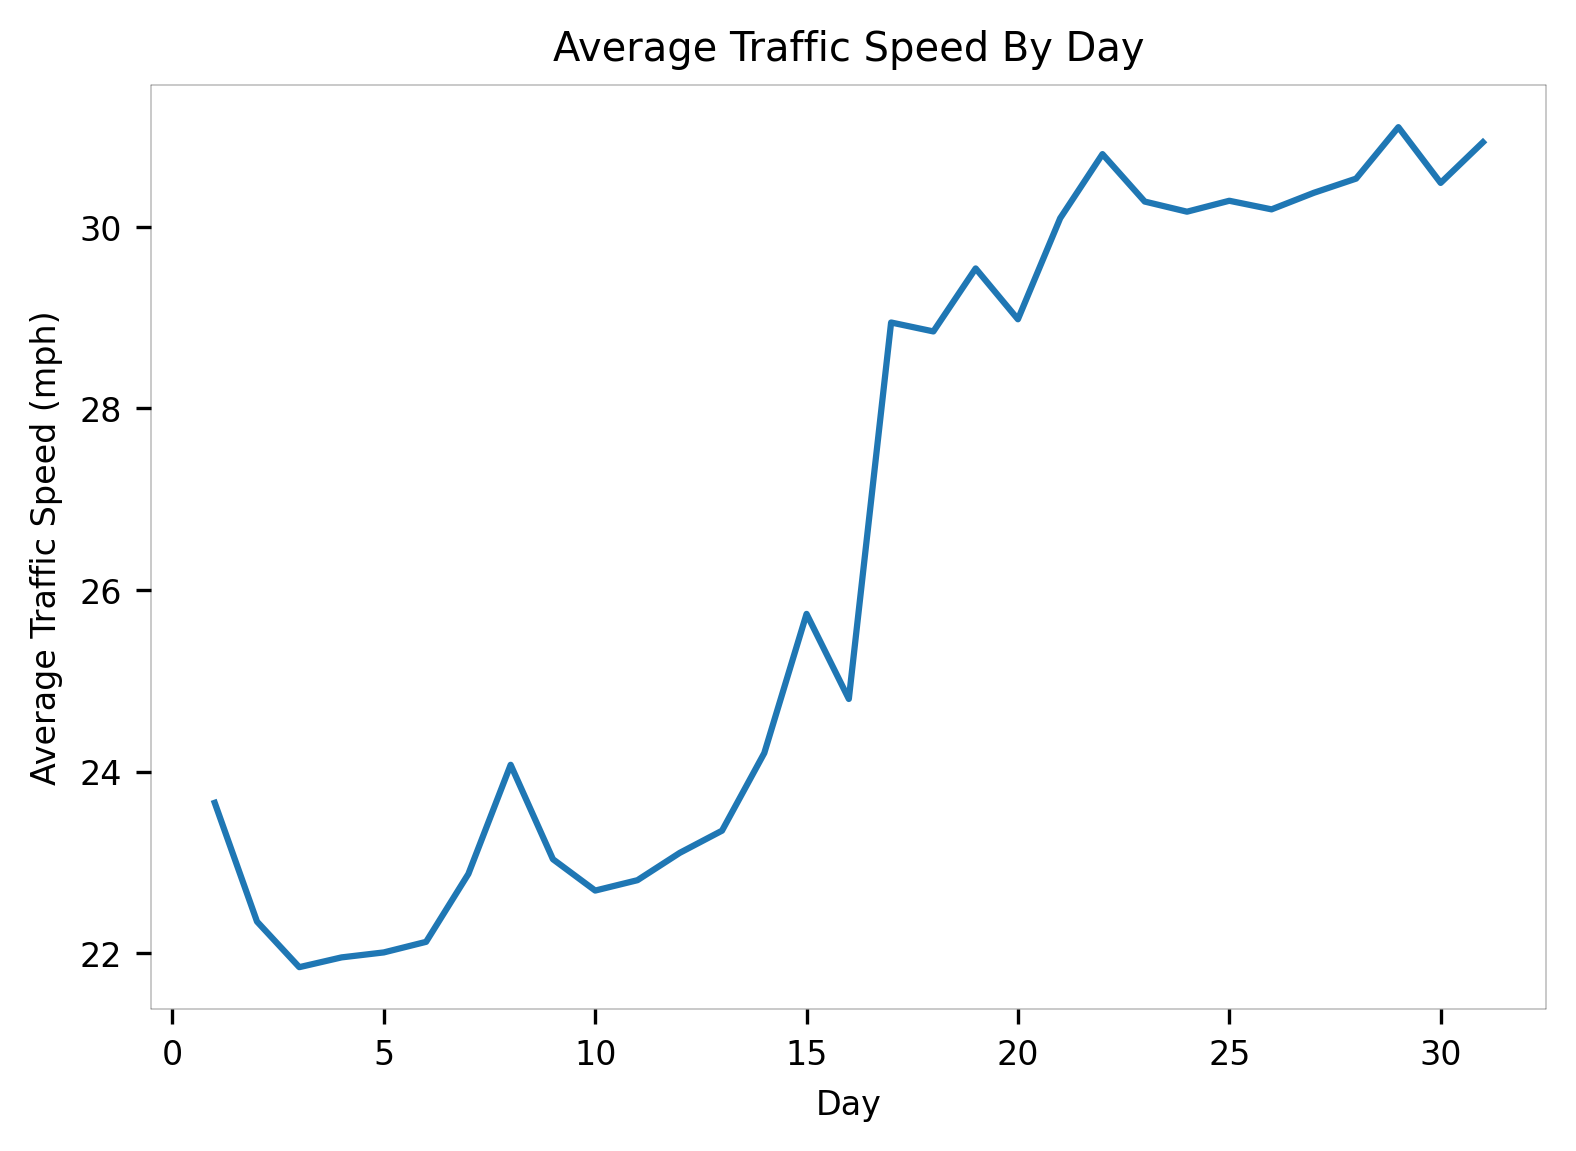

In [8]:
speeds_daily = speedGPS.groupby('day').mean(numeric_only=True).speed_mph_mean
plt.plot(speeds_daily.index.values, speeds_daily)
plt.title('Average Traffic Speed By Day')
plt.xlabel('Day')
plt.ylabel('Average Traffic Speed (mph)')
plt.show()

#### Correlations
The correlation for pre-lockdown and differences is lower than for post-lockdown, despite both being positive. The correlation for pre-lockdown is lower because more cars were on the road during that time, leading to higher differences from more variability between pre-lockdown speeds and differences. The correlation for post-lockdown is higher due to less traffic from fewer cars. Thus, there are fewer differences to calculate, and the variability between pre-lockdown speeds and differences is lower.

In [9]:
print('Average Speeds Correlation: Pre-Lockdown   vs Change:',
      f'{np.corrcoef(pre_post.speedPRE, pre_post.change)[0][1]:.3f}')
print('Average Speeds Correlation: Post-Lockdown  vs Change:',
      f'{np.corrcoef(pre_post.speedPOS, pre_post.change)[0][1]:.3f}')

Average Speeds Correlation: Pre-Lockdown   vs Change: 0.464
Average Speeds Correlation: Post-Lockdown  vs Change: 0.793


### Travel Time

- Starting address: 300 Hayes St, San Francisco, CA 94102
- Multiple destinations

#### Pre vs Post Lockdown

Travel time distribution shifts to the left after lockdown. The difference distribution mostly falls below 0, indicating decreases in time per tract.

##### Spatial Analysis

**Pre-Lockdown:** time increases with distance from the origin

**Difference:** time increased for some areas near, but generally decreased

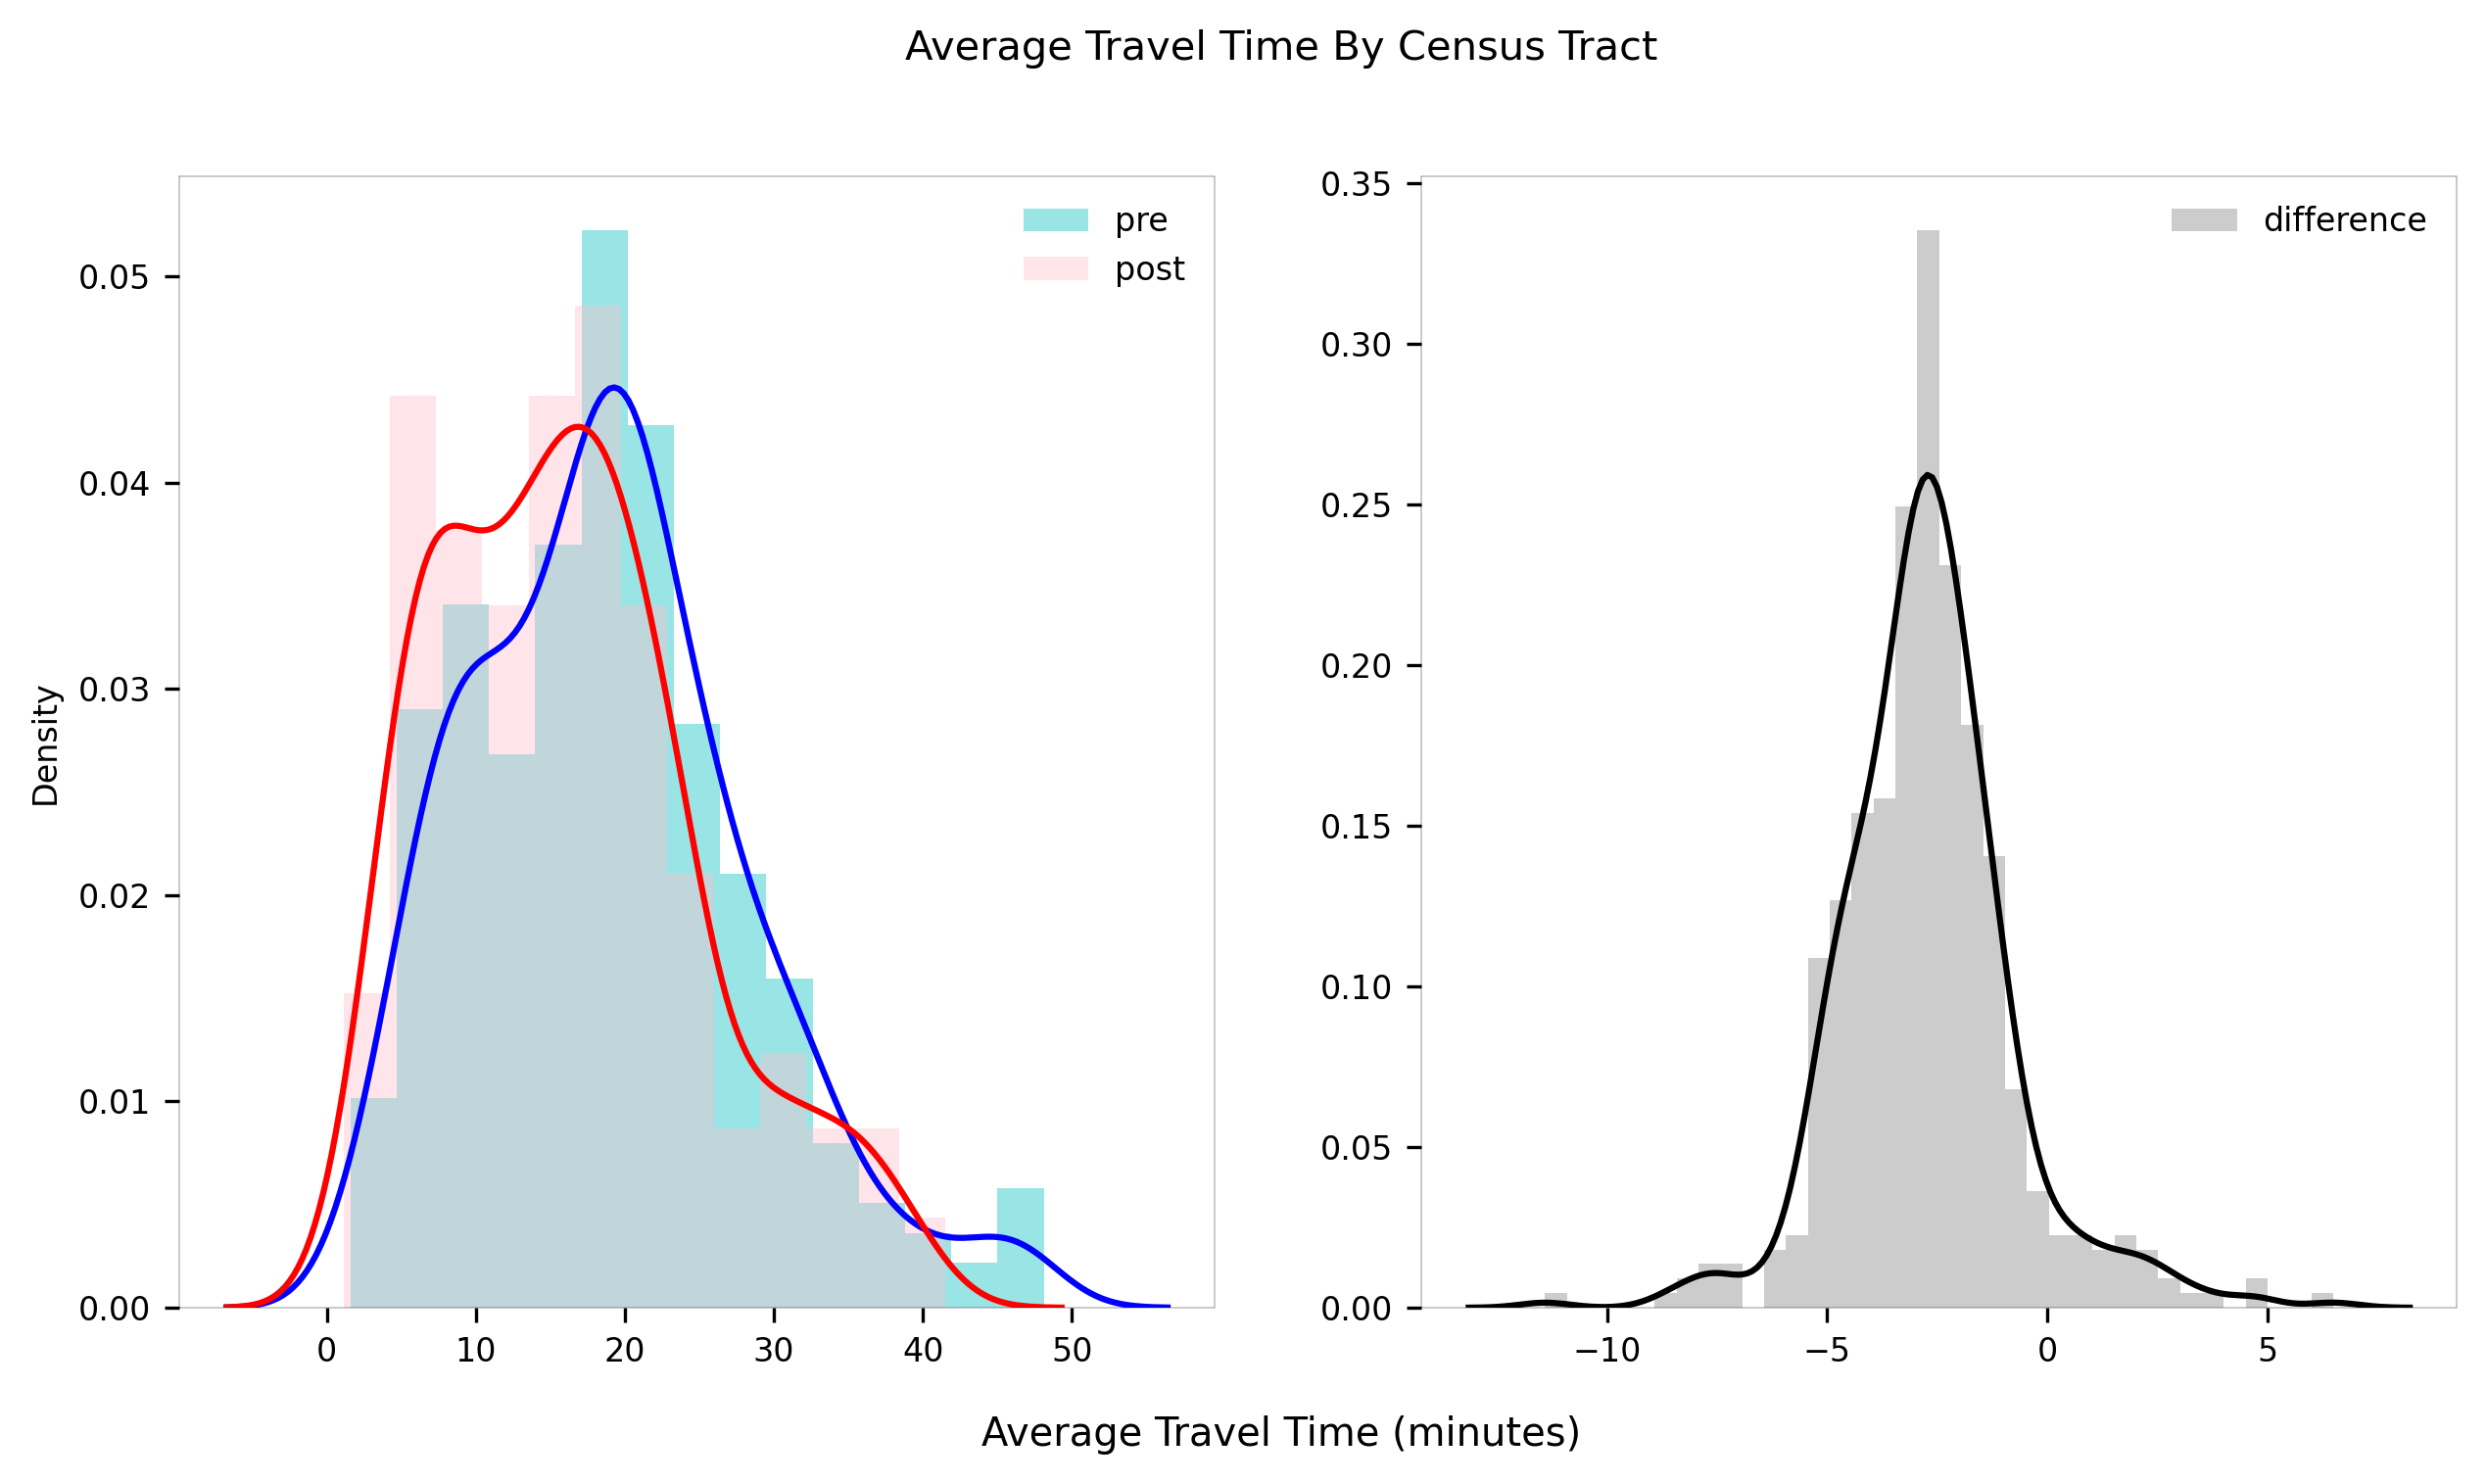

In [10]:
timePRE = times[times.day < 14].groupby(
    'destID', as_index=False).mean(numeric_only=True)
timePOS = times[times.day >= 14].groupby(
    'destID', as_index=False).mean(numeric_only=True)

pre_post_time = (timePRE.merge(timePOS, on='destID')
                 .rename(columns={'time_x': 'timePRE', 'time_y': 'timePOS', })
                 [['destID', 'timePRE', 'timePOS']]
                 )
pre_post_time['change'] = pre_post_time.timePOS - pre_post_time.timePRE
pre_post_time = (gpd.GeoDataFrame(pre_post_time.merge(
    bound, left_on='destID', right_on='MOVEMENT_ID'))
    .set_index('destID'))
# display(pre_post_time.describe().iloc[1:, :-1])

del timePRE, timePOS

plotDist(df=pre_post_time, col=['timePRE', 'timePOS'],
         title='Average Travel Time By Census Tract',
         x='Average Travel Time (minutes)')
plotChoro(df=pre_post_time, col=['timePRE', 'timePOS', 'change'],
          var='Time (minutes)')

#### Day of Week on Travel Time
Travel time experienced more change on weekdays than on weekends, likely due to people working from home and no longer needing to drive to work. Weekend traffic is consistent throughout the day, so travel time did not change much.

In [11]:
# Average Travel Time By Day of the Week
days = ['sun', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat']
times['day_of_week'] = (times.day % 7).replace([1, 2, 3, 4, 5, 6, 0], days)

# Difference by Day
dayPRE = times[times['day'] < 14].groupby(
    ['destID', 'day_of_week']).mean(numeric_only=True)
dayPOS = times[times['day'] >= 14].groupby(
    ['destID', 'day_of_week']).mean(numeric_only=True)
pre_post_day = dayPRE.merge(dayPOS, left_index=True, right_index=True) \
    .rename(columns={'time_x': 'timePRE', 'time_y': 'timePOS'})
pre_post_day['change'] = pre_post_day.timePOS - pre_post_day.timePRE
pre_post_day['relChange'] = pre_post_day.change / pre_post_day.timePRE

# Extract City Names
# pre_post_day['city'] = pre_post_day['destName'].str.split(', ').str[-1]

del dayPRE, dayPOS

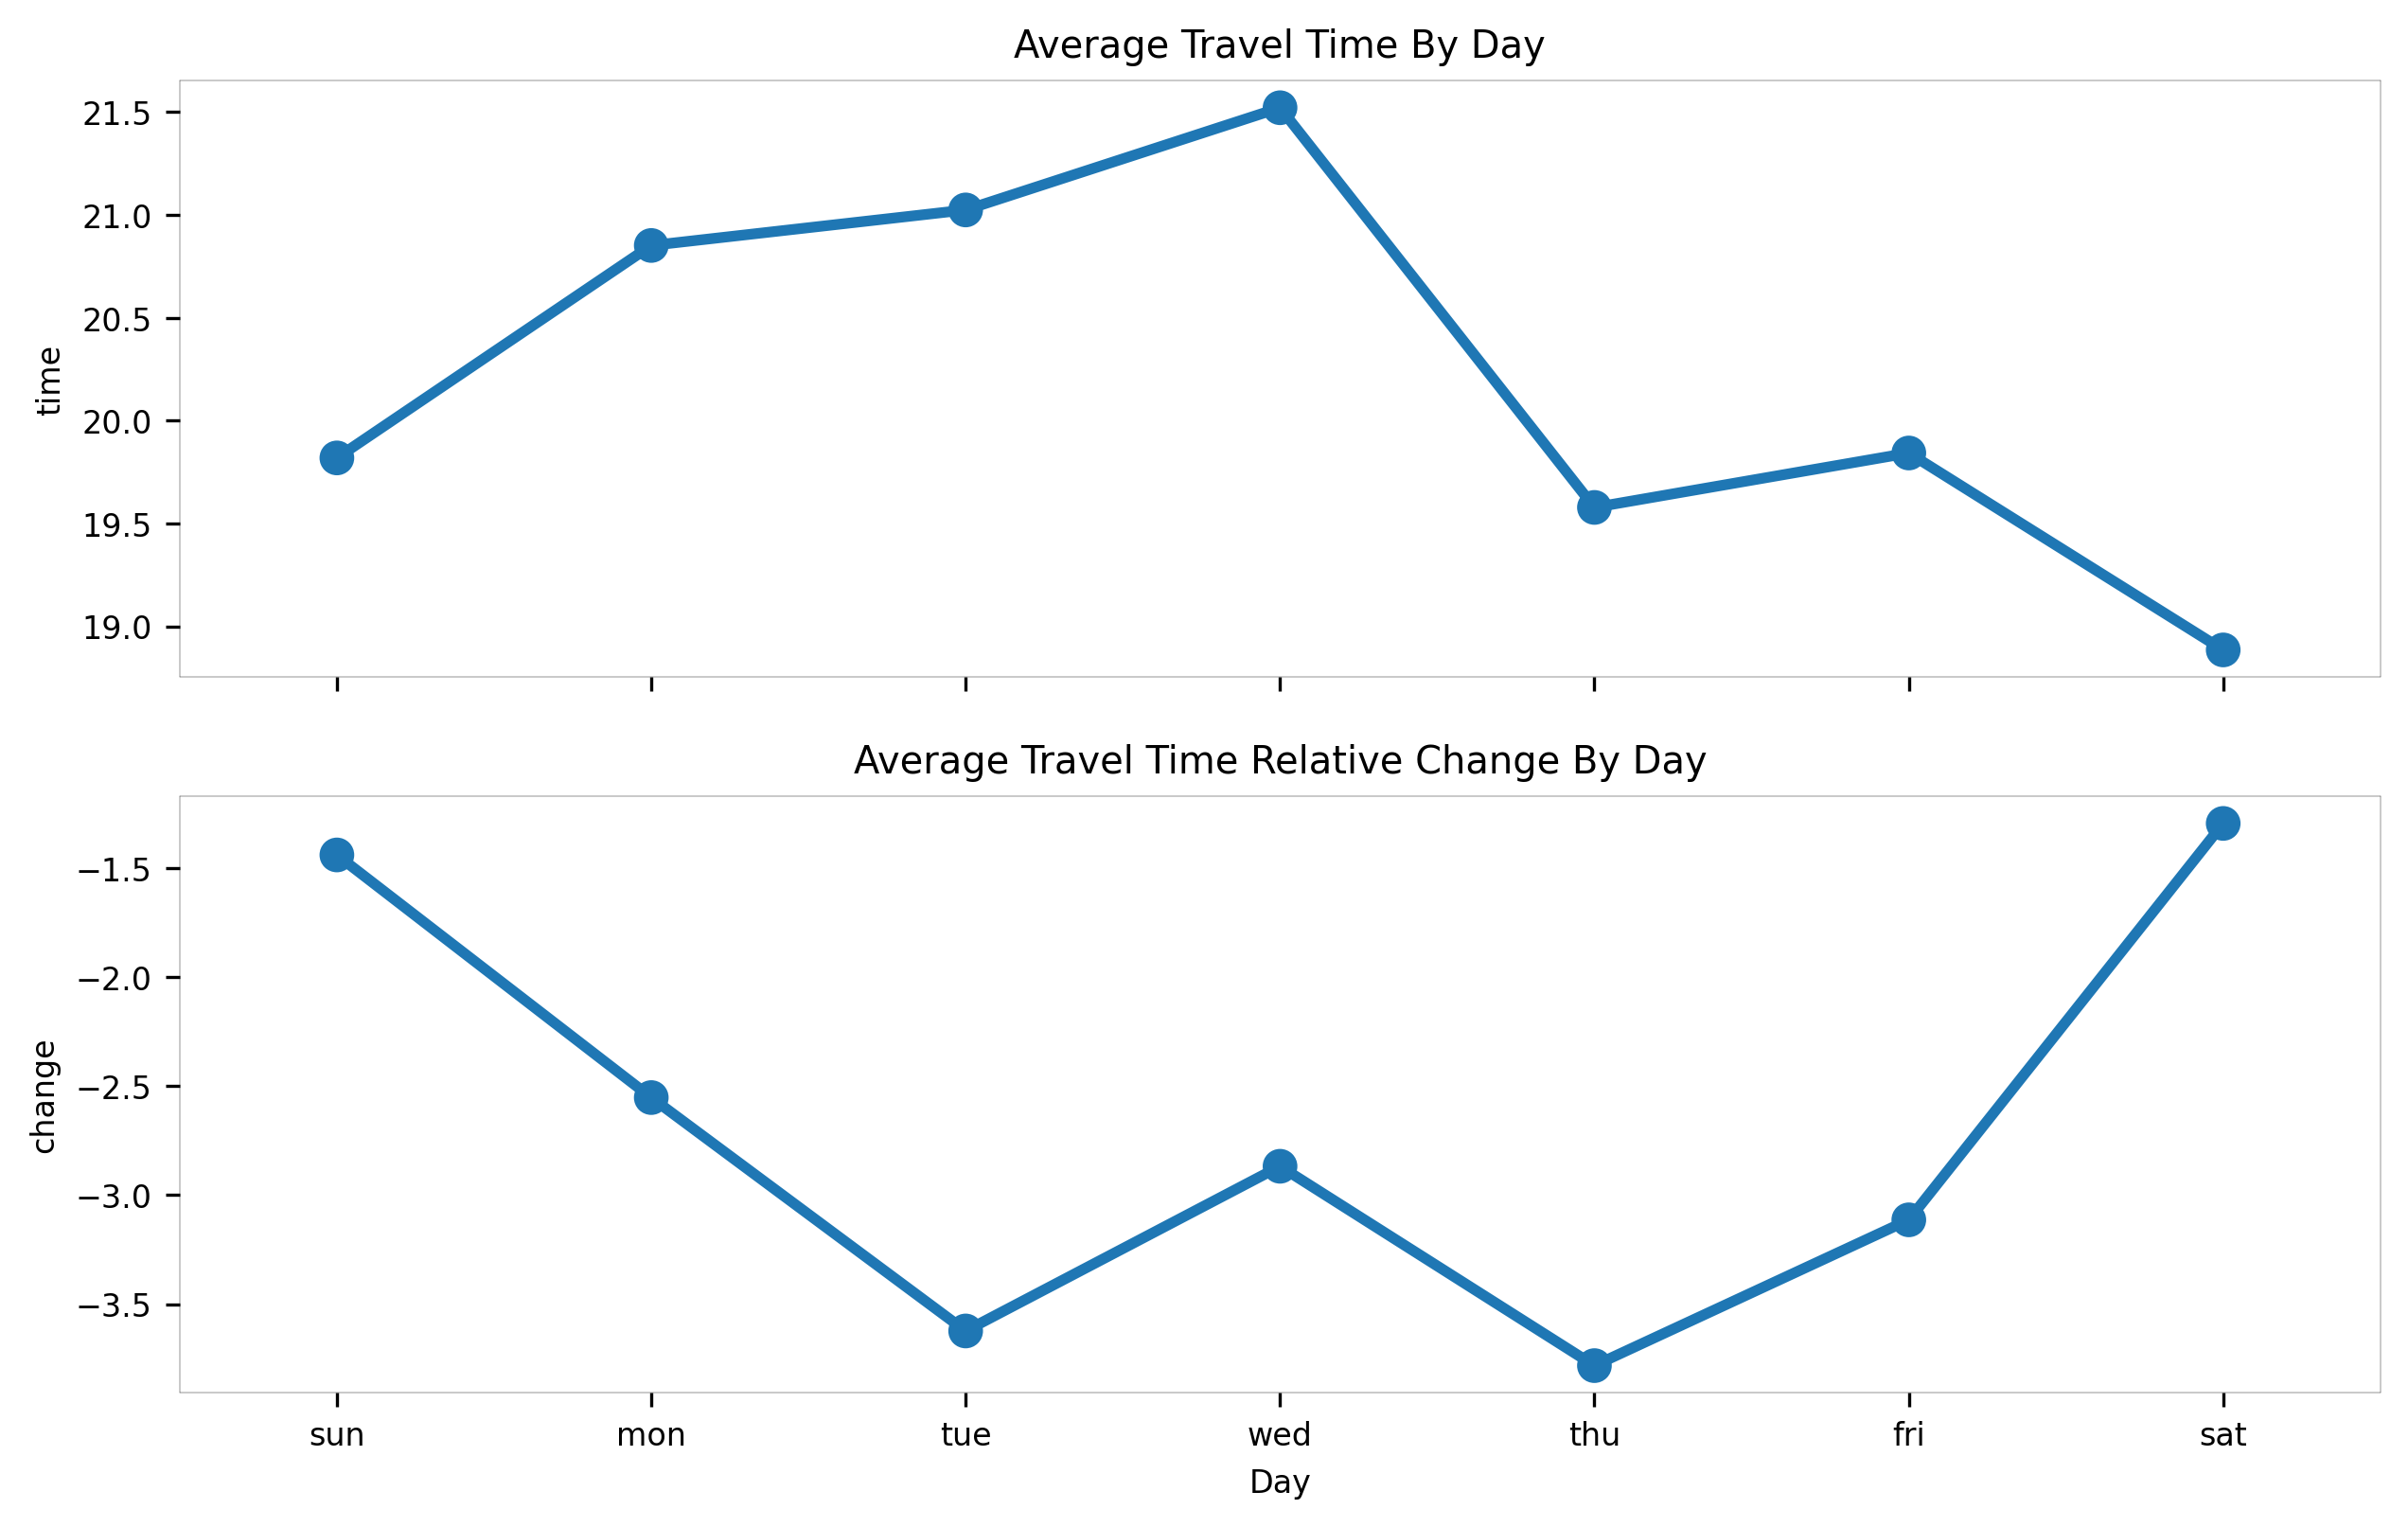

In [12]:
by_day = (times.groupby(['destID', 'day_of_week'], as_index=False).mean(numeric_only=True)
          .groupby('day_of_week').mean().reindex(days)[['time']])
diff_day = pre_post_day.groupby('day_of_week').mean().reindex(days)

fig, axs = plt.subplots(nrows=2, figsize=(10, 6), sharex=True, squeeze=True)
sns.pointplot(data=by_day, x=by_day.index, y='time', ax=axs[0])
sns.pointplot(data=diff_day, x=diff_day.index, y='change', ax=axs[1])

axs[0].set(title='Average Travel Time By Day', xlabel='')
axs[1].set(title='Average Travel Time Relative Change By Day', xlabel='Day')
plt.show()

del by_day, diff_day

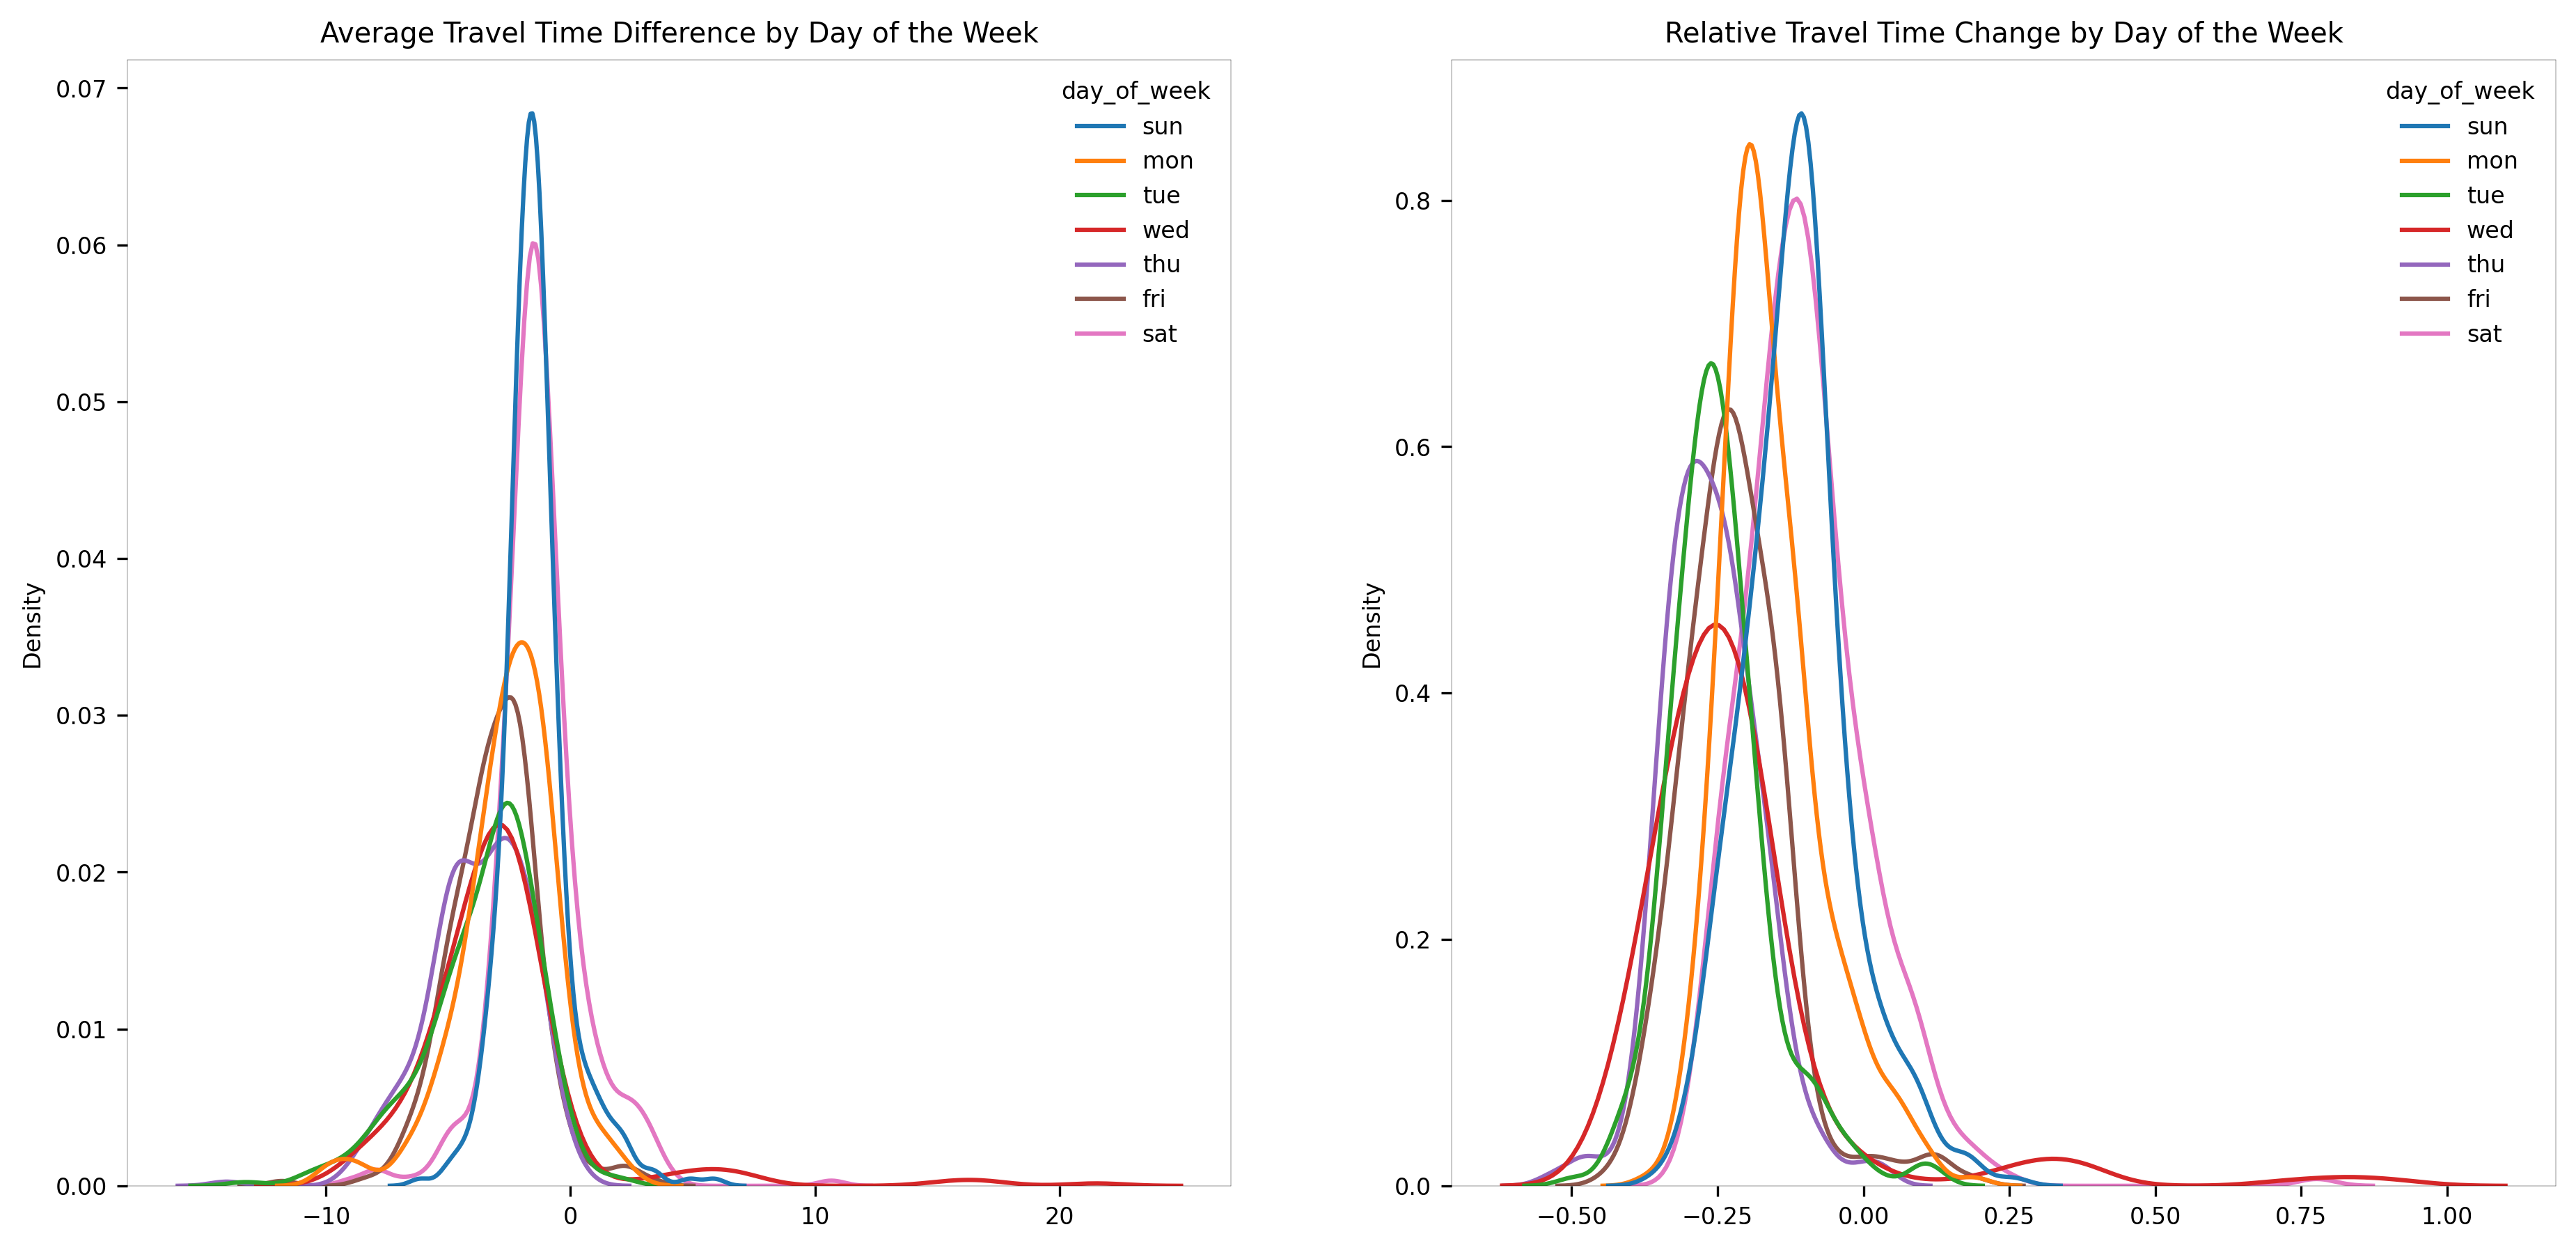

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 7))
sns.kdeplot(data=pre_post_day, hue='day_of_week',
            hue_order=days, x='change', ax=axs[0])
sns.kdeplot(data=pre_post_day, hue='day_of_week',
            hue_order=days, x='relChange', ax=axs[1])

axs[0].set(title='Average Travel Time Difference by Day of the Week', xlabel='')
axs[1].set(title='Relative Travel Time Change by Day of the Week', xlabel='')
plt.show()

## Modeling

### Model 1:

- Linear regression: train on prelockdown
- Independent: speeds on day x
- Dependent: speeds before day x

In [14]:
ts = (speedGPS[['day', 'speed_mph_mean', 'MOVEMENT_ID']]
      .groupby(['MOVEMENT_ID', 'day']).mean().unstack())
display(ts.head(2))

speed_mph_mean                                              \
day                     1          2          3          4          5    
MOVEMENT_ID                                                              
9                16.196918  14.395122  13.868696  14.225414  14.312200   
20               17.377148  15.440970  15.554703  15.404189  15.442083   

                                                                    ...  \
day                 6          7          8          9          10  ...   
MOVEMENT_ID                                                         ...   
9            13.811991  15.508636  16.210739  14.845320  14.711534  ...   
20           15.308080  17.128344  18.117357  16.199888  15.311864  ...   

                                                                               \
day                 22         23         24         25         26         27   
MOVEMENT_ID                                                                     
9            15.880077  17.019573  15.527393  15.925605  15.959743  17.317841   
20           18.977848  17.648558  16.558846  17.798622  15.413944  18.207773   

                                                         
day                 28         29         30         31  
MOVEMENT_ID                                              
9            17.845055  17.839212  15.743376  15.797247  
20           17.123478  19.024969  15.200414  18.032948  

[2 rows x 31 columns]

train r2: 0.919
val r2: 0.964


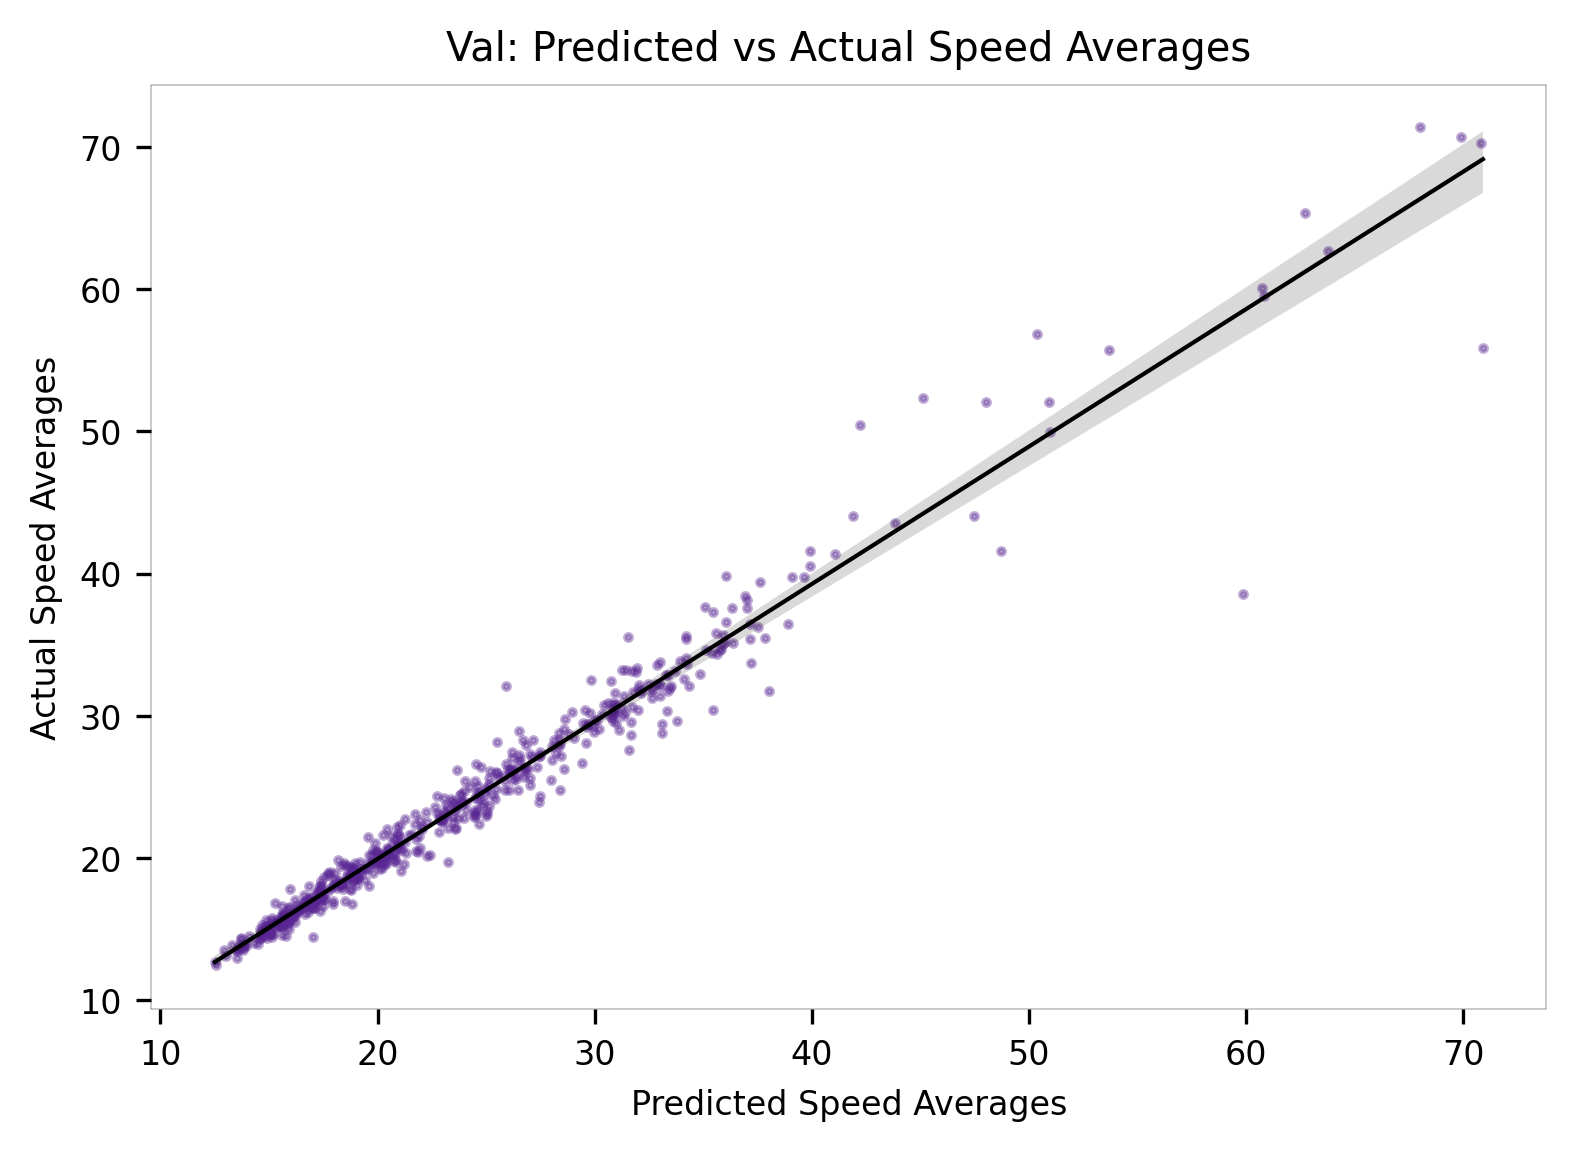

test r2: 0.934


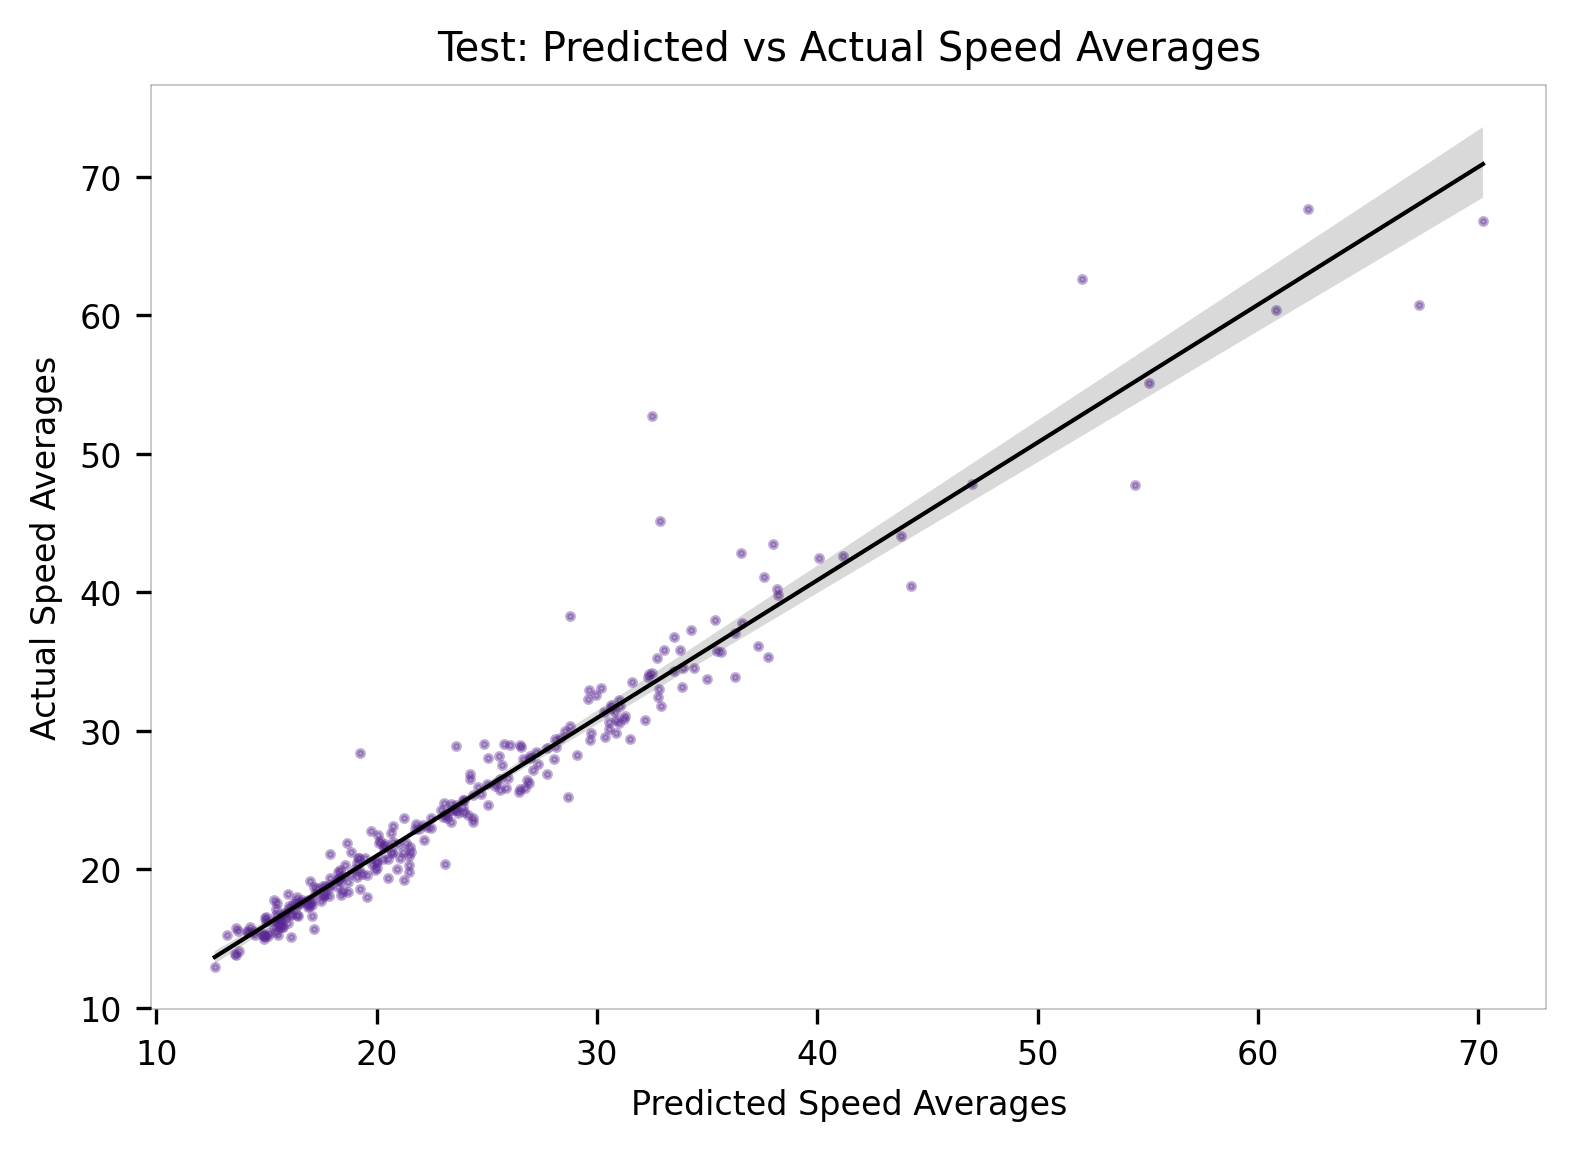

In [15]:
# train and evaluate using days within prelockdown
# X_train (day 1-5), y_train (day 6), X_val (day 7-11), y_val (day 12-13)
model1 = trainTS(ts_to_ds(ts.iloc[:, :13], 5, 2), plotV=True)

# test on end of prelockdown
# X_train (day 1-5), y_train (day 6), X_test (day 9-13), y_test (day 14)
_ = trainTS(ts_to_ds(ts.iloc[:, 8:14], 5, 0), model=model1, plotT=True)

### Issues

**Day 17 dip:** shelter in place was enacted on the 17th, severely restricting travel, so speed data from the days prior wouldn't be able to predict this external policy. ([Bay Area Covid timeline](https://abc7news.com/timeline-of-coronavirus-us-covid-19-bay-area-sf/6047519/))

**Day 15 decline:** performances worsen on the 15th when Newsom ordered elderlies to stay home and reduce restaurant capacity. This would again affect traffic beyond  just looking at previous days' speeds could predict.

**Day 8 dip:** foreshadowed in [speeds_daily plot](#speeds_daily)  where there is a sudden spike in average speed, which probably caused the model accuracy to decrease. The model recovers possibly because of the speed declining back to its 'normal' state. Without the spike, there seems to be a gradual increase in traffic speed between the 5th and the 10th.

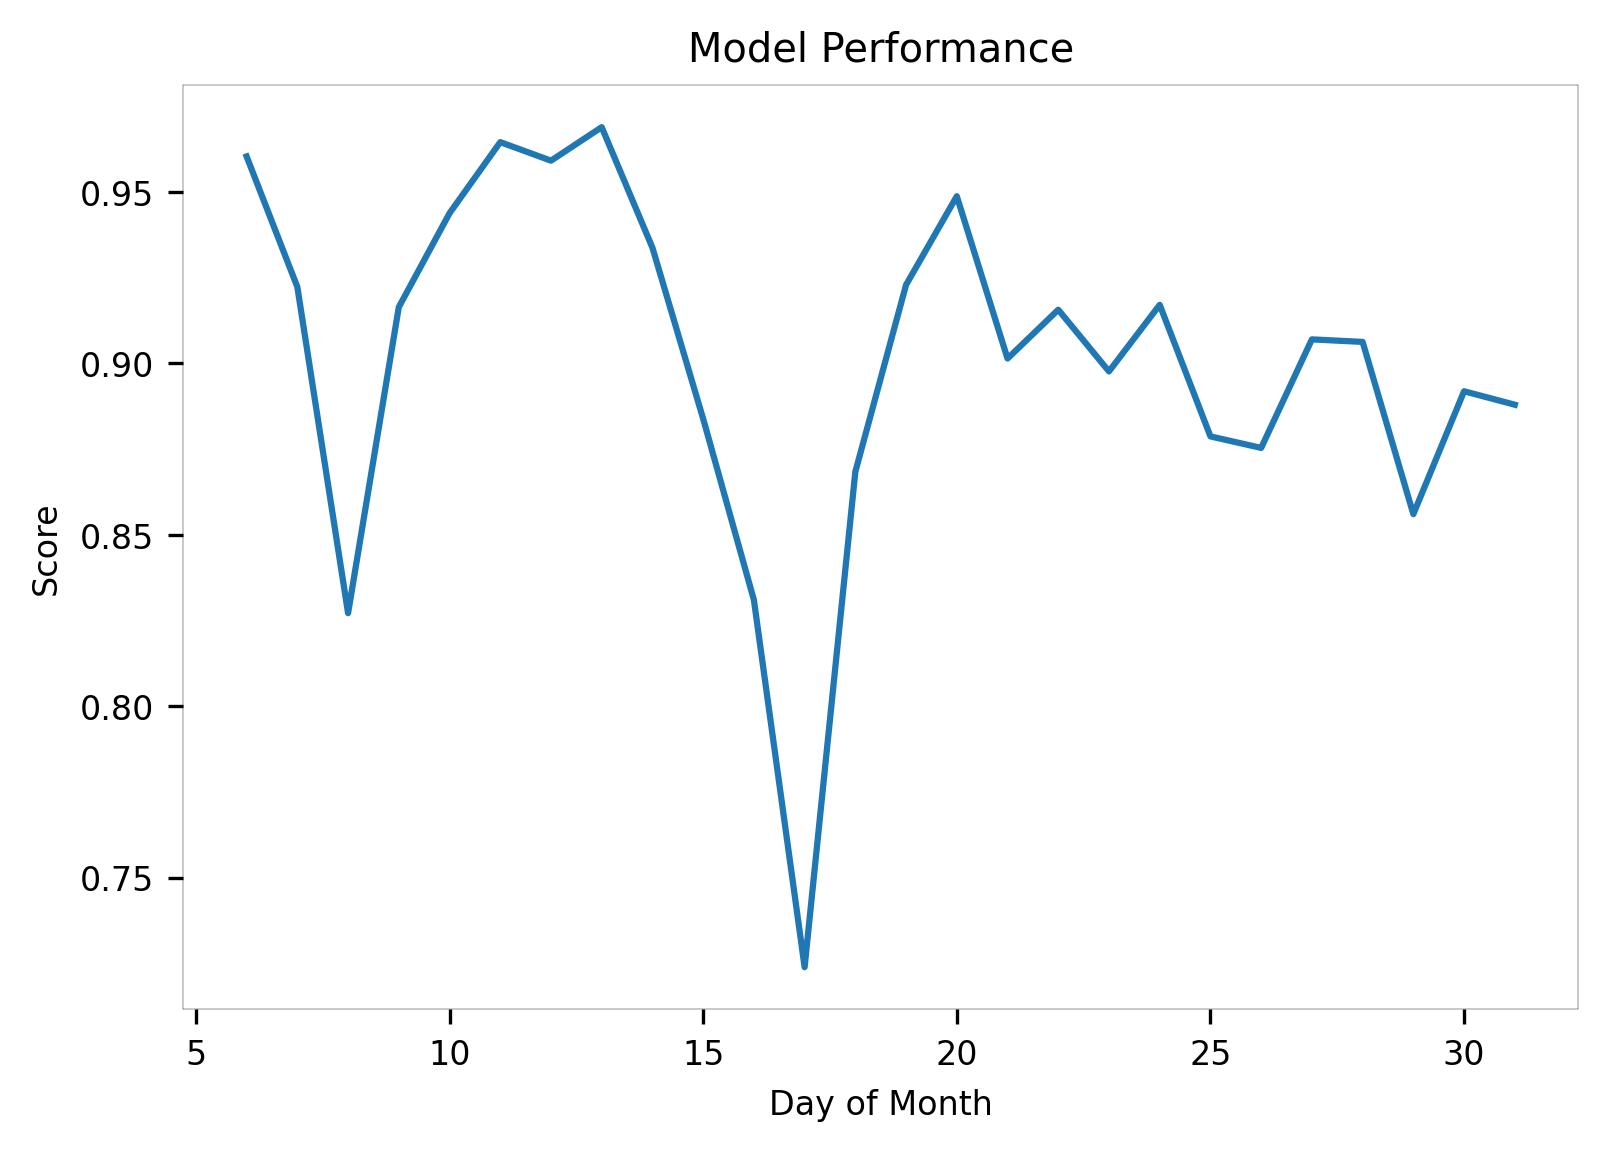

In [16]:
performance(model=model1, ts=ts, start=5)

test r2: 0.724


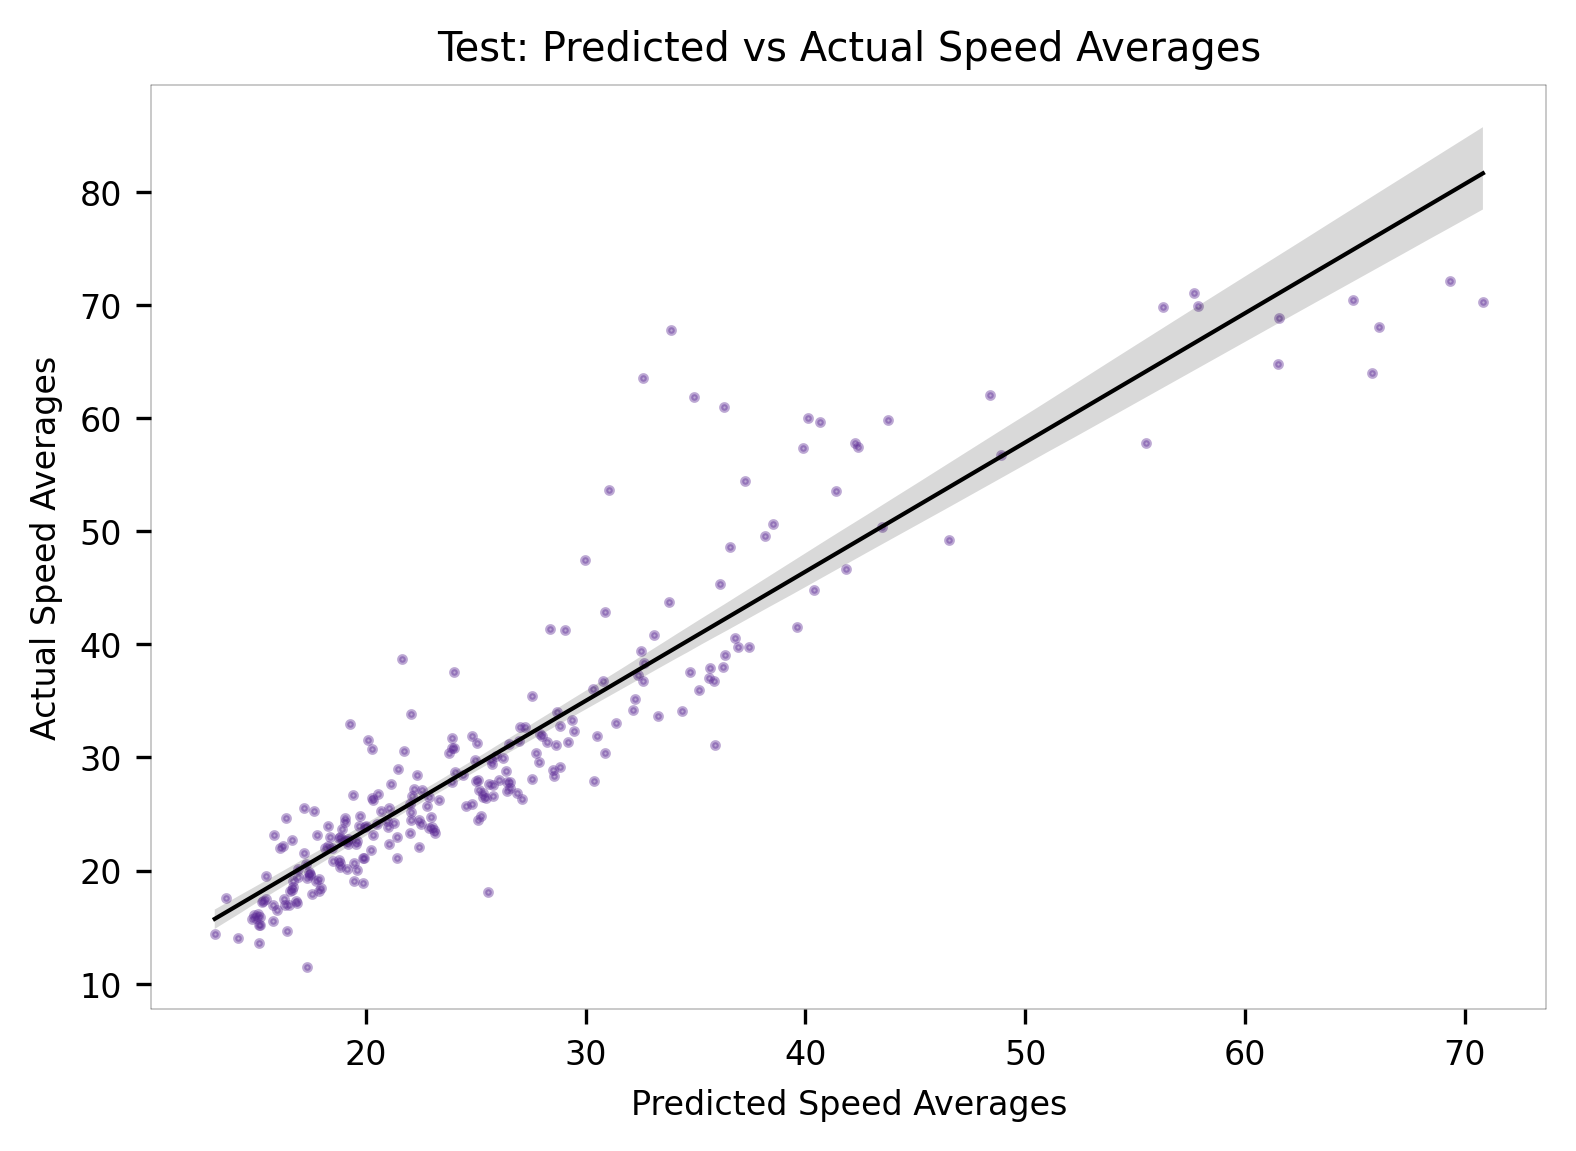

In [17]:
# test on end of prelockdown with dip: bad score
# X_train (day 1-5), y_train (day 6), X_test (day 12-16), y_test (day 17)
_ = trainTS(ts_to_ds(ts.iloc[:, 11:17], 5, 0), model=model1, plotT=True)

test r2: 0.903


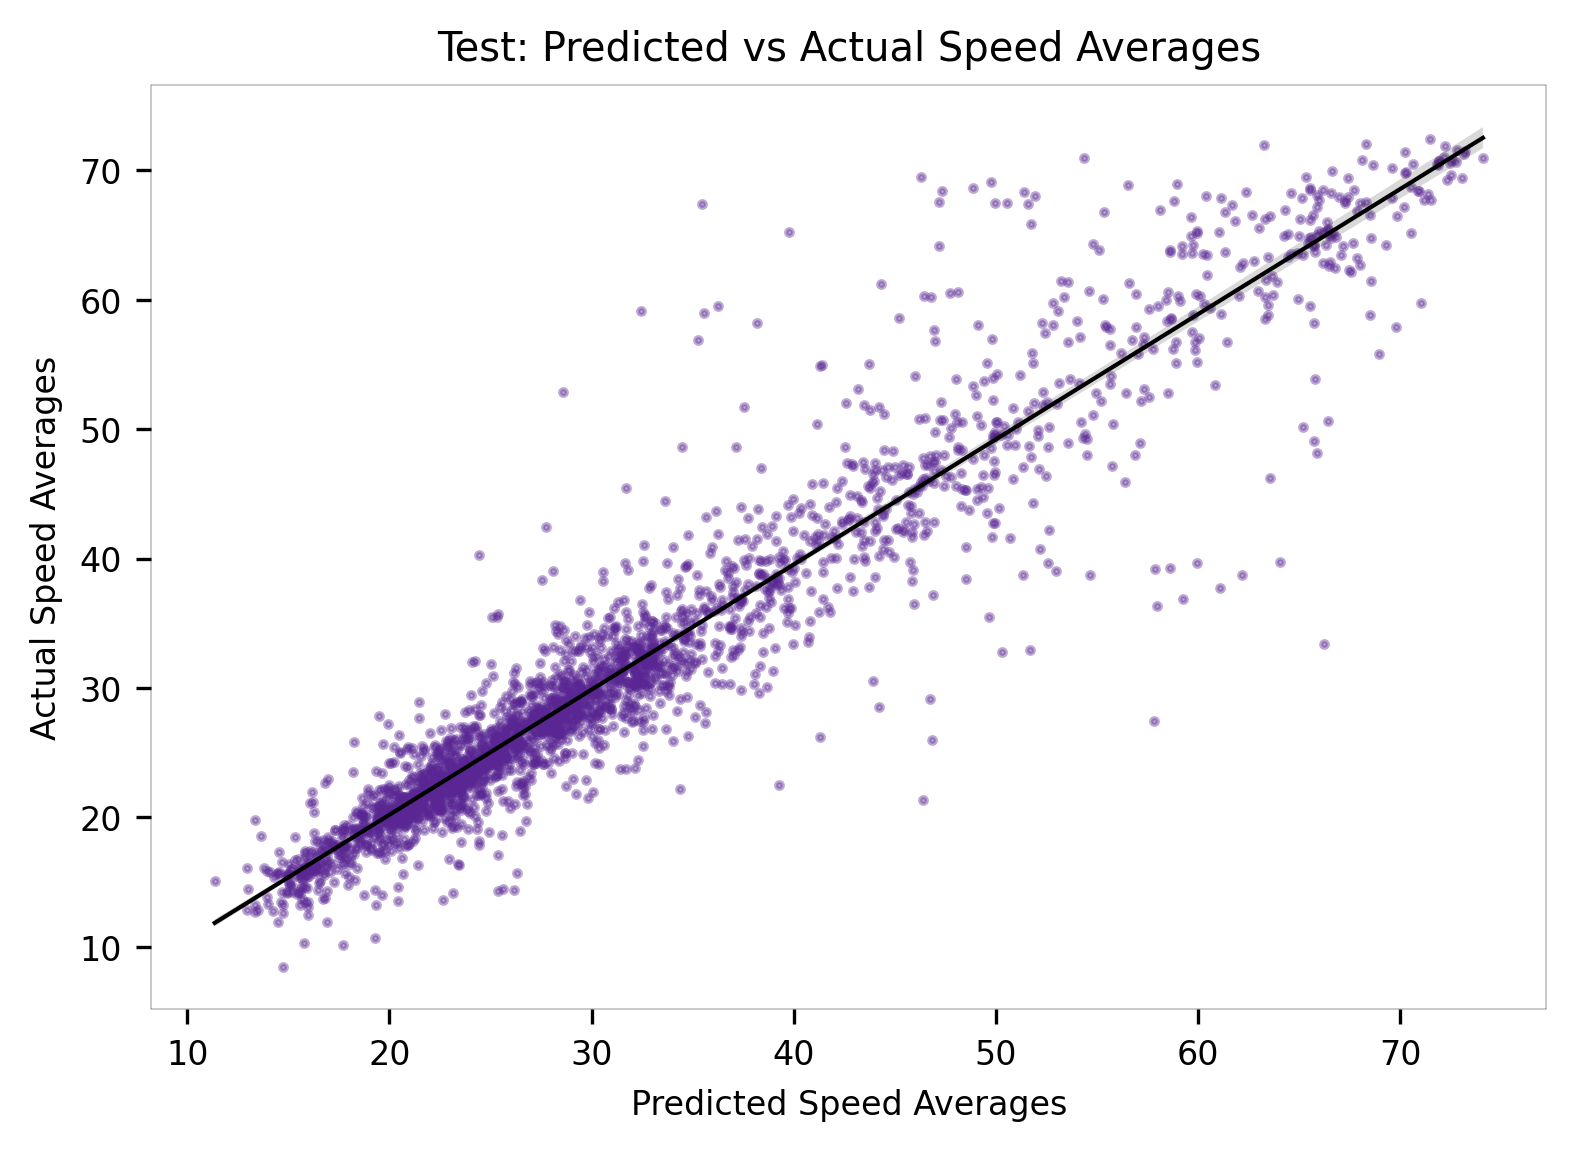

In [18]:
# test on postlockdown
# X_train (day 1-5), y_train (day 6), X_test (day 14-18), y_test (day 19)
_ = trainTS(ts_to_ds(ts.iloc[:, 13:], 5, 0), model=model1, plotT=True)

### Model 2:

- Linear regression: train on prelockdown; centered days
- Independent: speeds on day x
- Dependent: speeds before day x

Model 2 performed better than 1: predicting changes in velocity after centering the data accounts for the drastic speed increase that interfered with model 1; pre and post-lockdown speed deltas are more consistent with one another

In [19]:
ts_delta = ts - np.array(speeds_daily)
ts_delta.head(2)

speed_mph_mean                                                    \
day                     1         2         3         4         5         6    
MOVEMENT_ID                                                                    
9                -7.459633 -7.953498 -7.977951 -7.728899 -7.696921 -8.313604   
20               -6.279404 -6.907649 -6.291945 -6.550124 -6.567038 -6.817515   

                                                     ...             \
day                7         8         9         10  ...         22   
MOVEMENT_ID                                          ...              
9           -7.364792 -7.864122 -8.190079 -7.978547  ... -14.919285   
20          -5.745085 -5.957504 -6.835510 -7.378217  ... -11.821514   

                                                                               \
day                 23         24         25         26         27         28   
MOVEMENT_ID                                                                     
9           -13.257315 -14.637932 -14.360063 -14.231266 -13.055407 -12.684528   
20          -12.628330 -13.606480 -12.487045 -14.777065 -12.165474 -13.406105   

                                              
day                 29         30         31  
MOVEMENT_ID                                   
9           -13.256826 -14.738958 -15.132729  
20          -12.071070 -15.281920 -12.897028  

[2 rows x 31 columns]

train r2: 0.930
val r2: 0.964


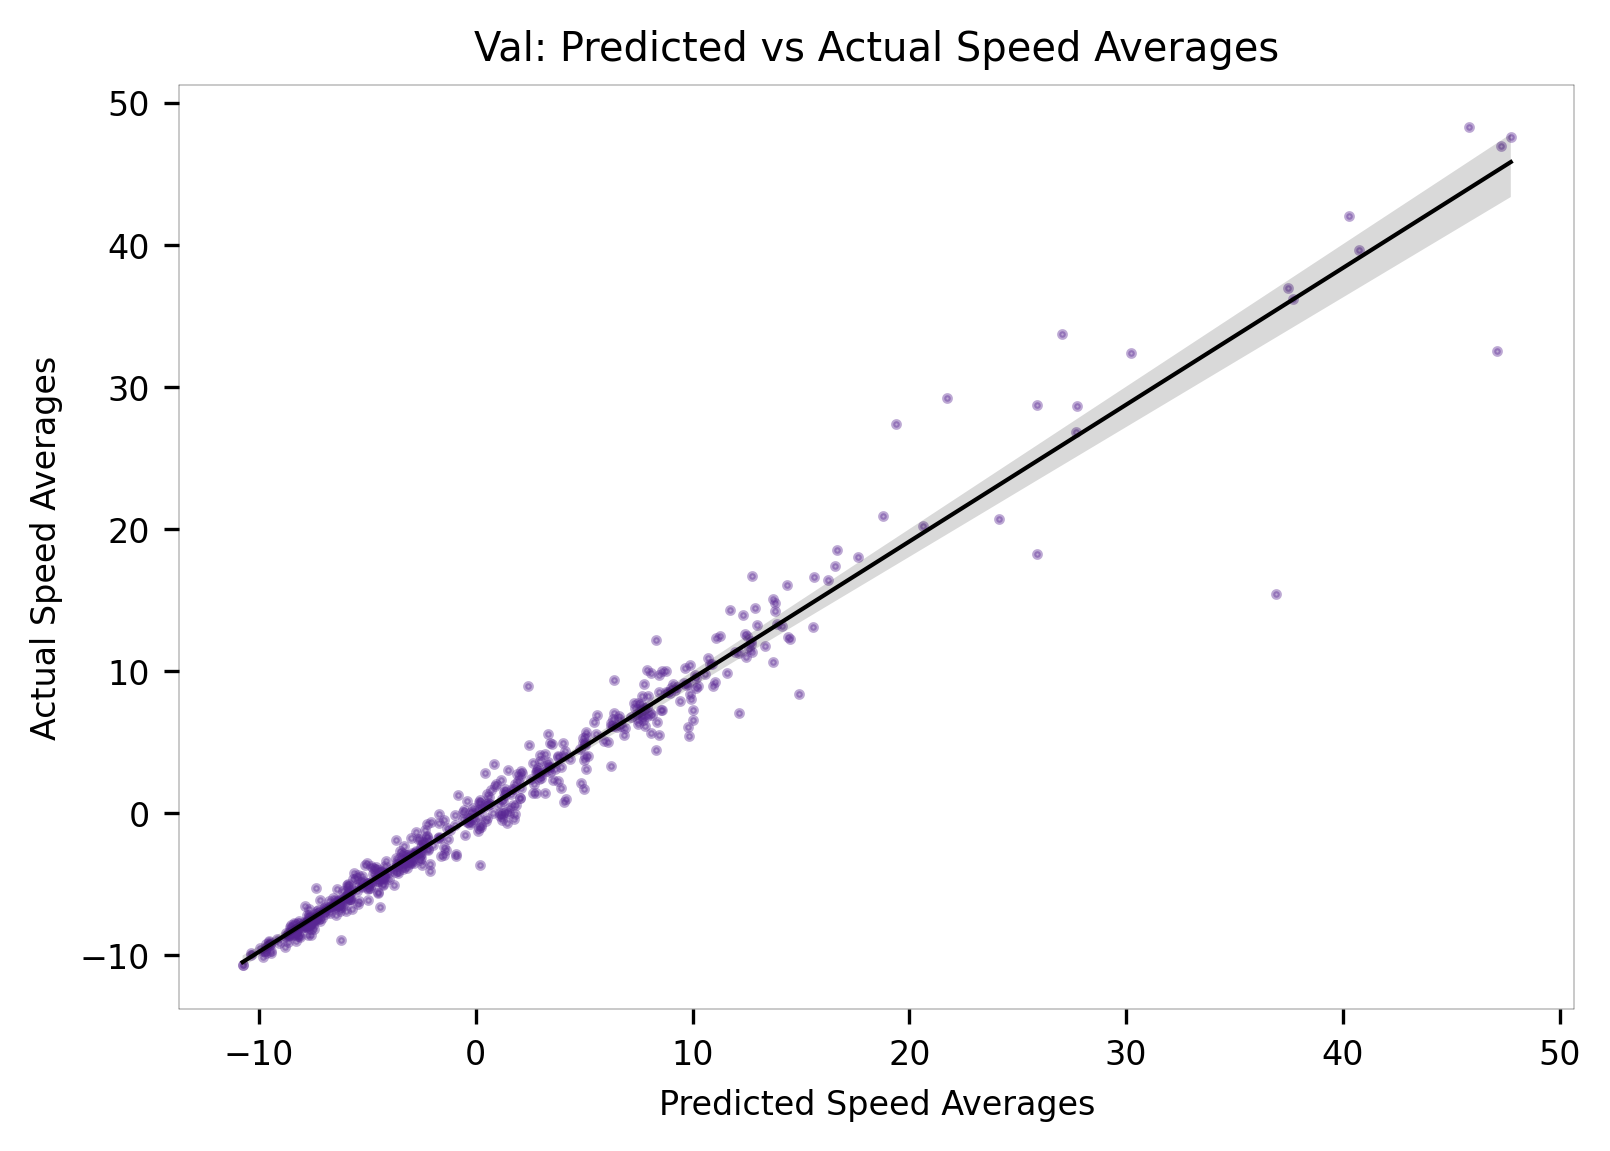

test r2: 0.834


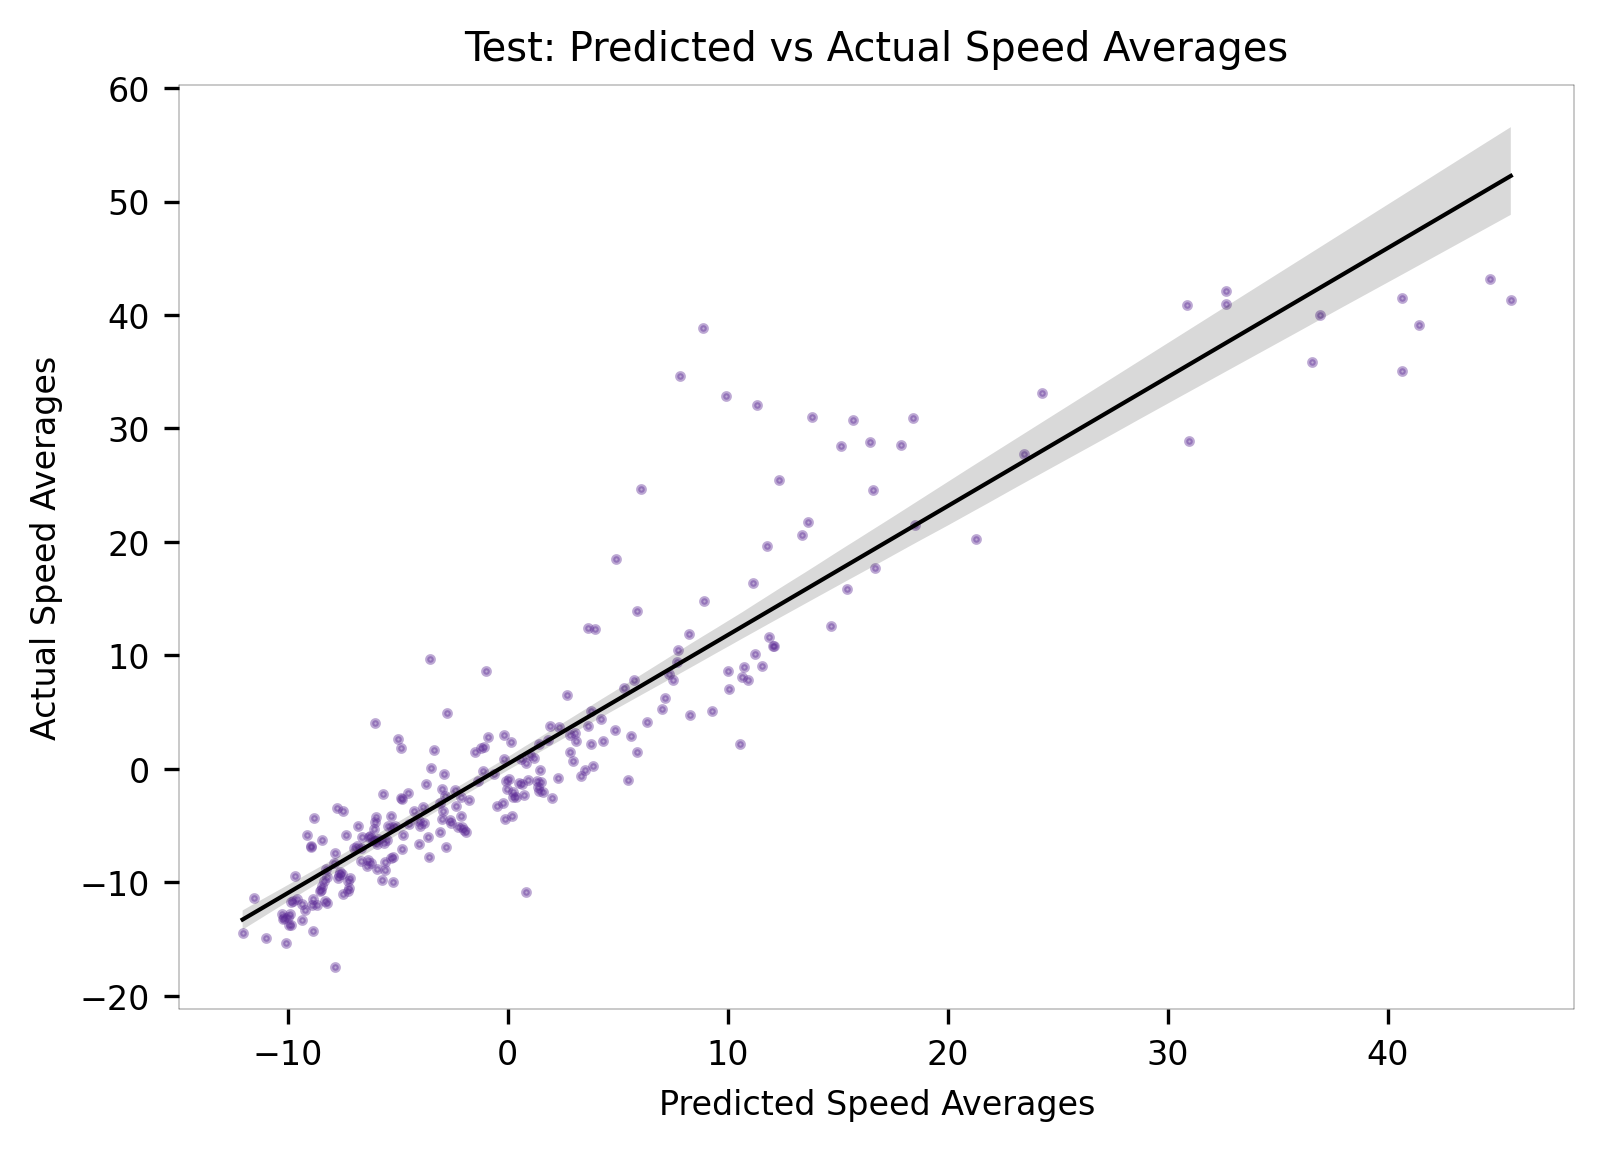

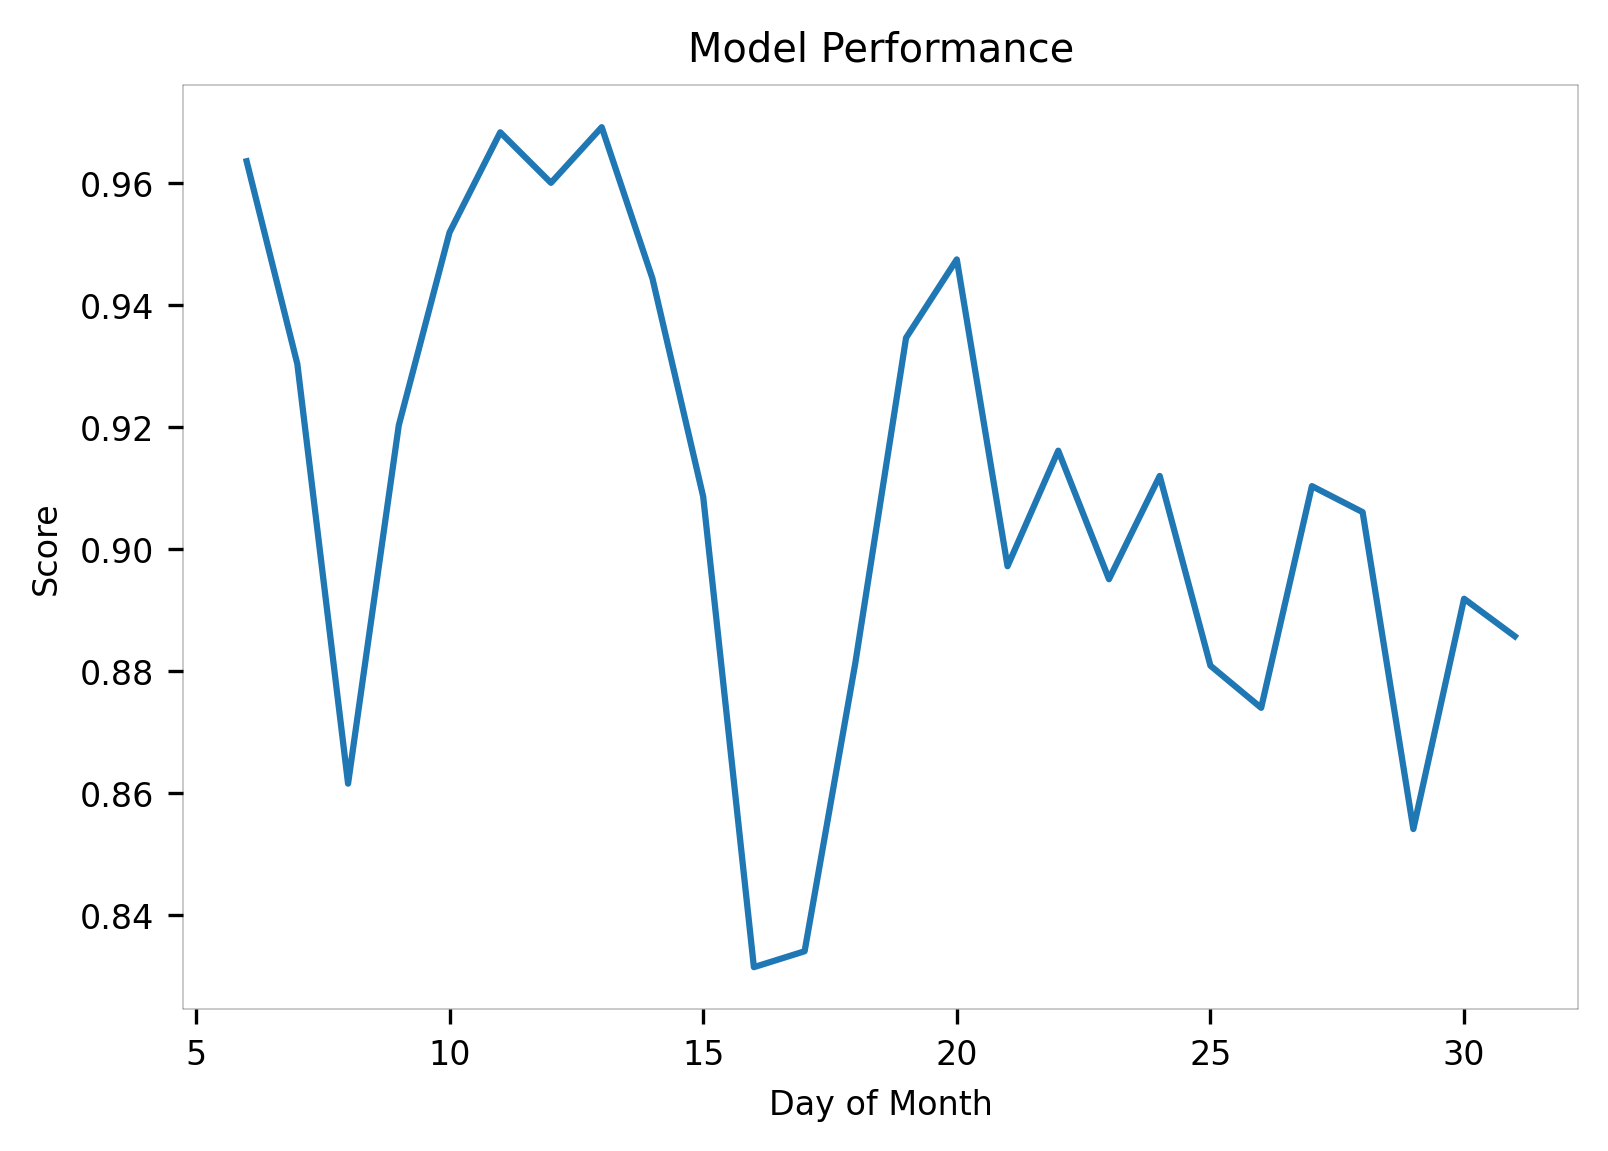

In [20]:
# train and evaluate using days within prelockdown
# X_train (day 1-5), y_train (day 6), X_val (day 7-11), y_val (day 12-13)
model2 = trainTS(ts_to_ds(ts_delta.iloc[:, :13], 5, 2), plotV=True)

# test on end of prelockdown with dip
# X_train (day 1-5), y_train (day 6), X_test (day 12-16), y_test (day 17)
_ = trainTS(ts_to_ds(ts_delta.iloc[:, 11:17], 5, 0), model=model2, plotT=True)

performance(model=model2, ts=ts_delta, start=5)

### Model 3:

- Linear regression: train on postlockdown
- Independent: speeds on day x
- Dependent: speeds before day x

train r2: 0.908
val r2: 0.899


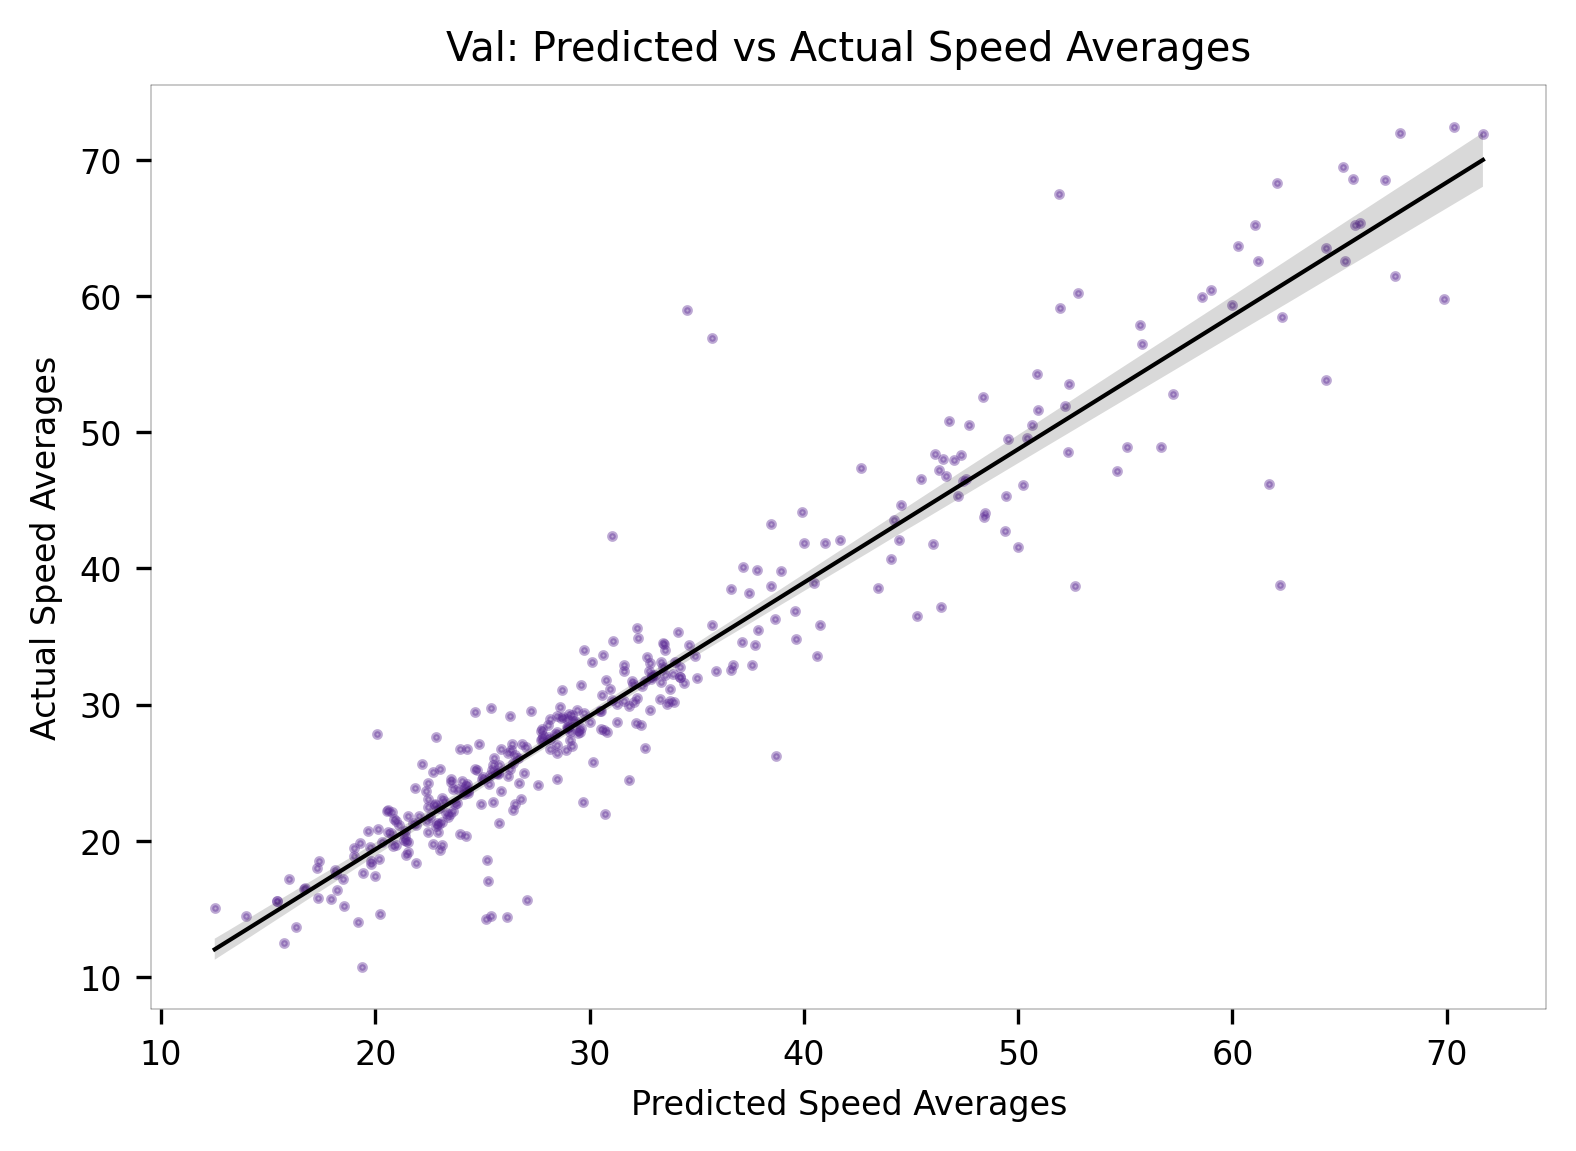

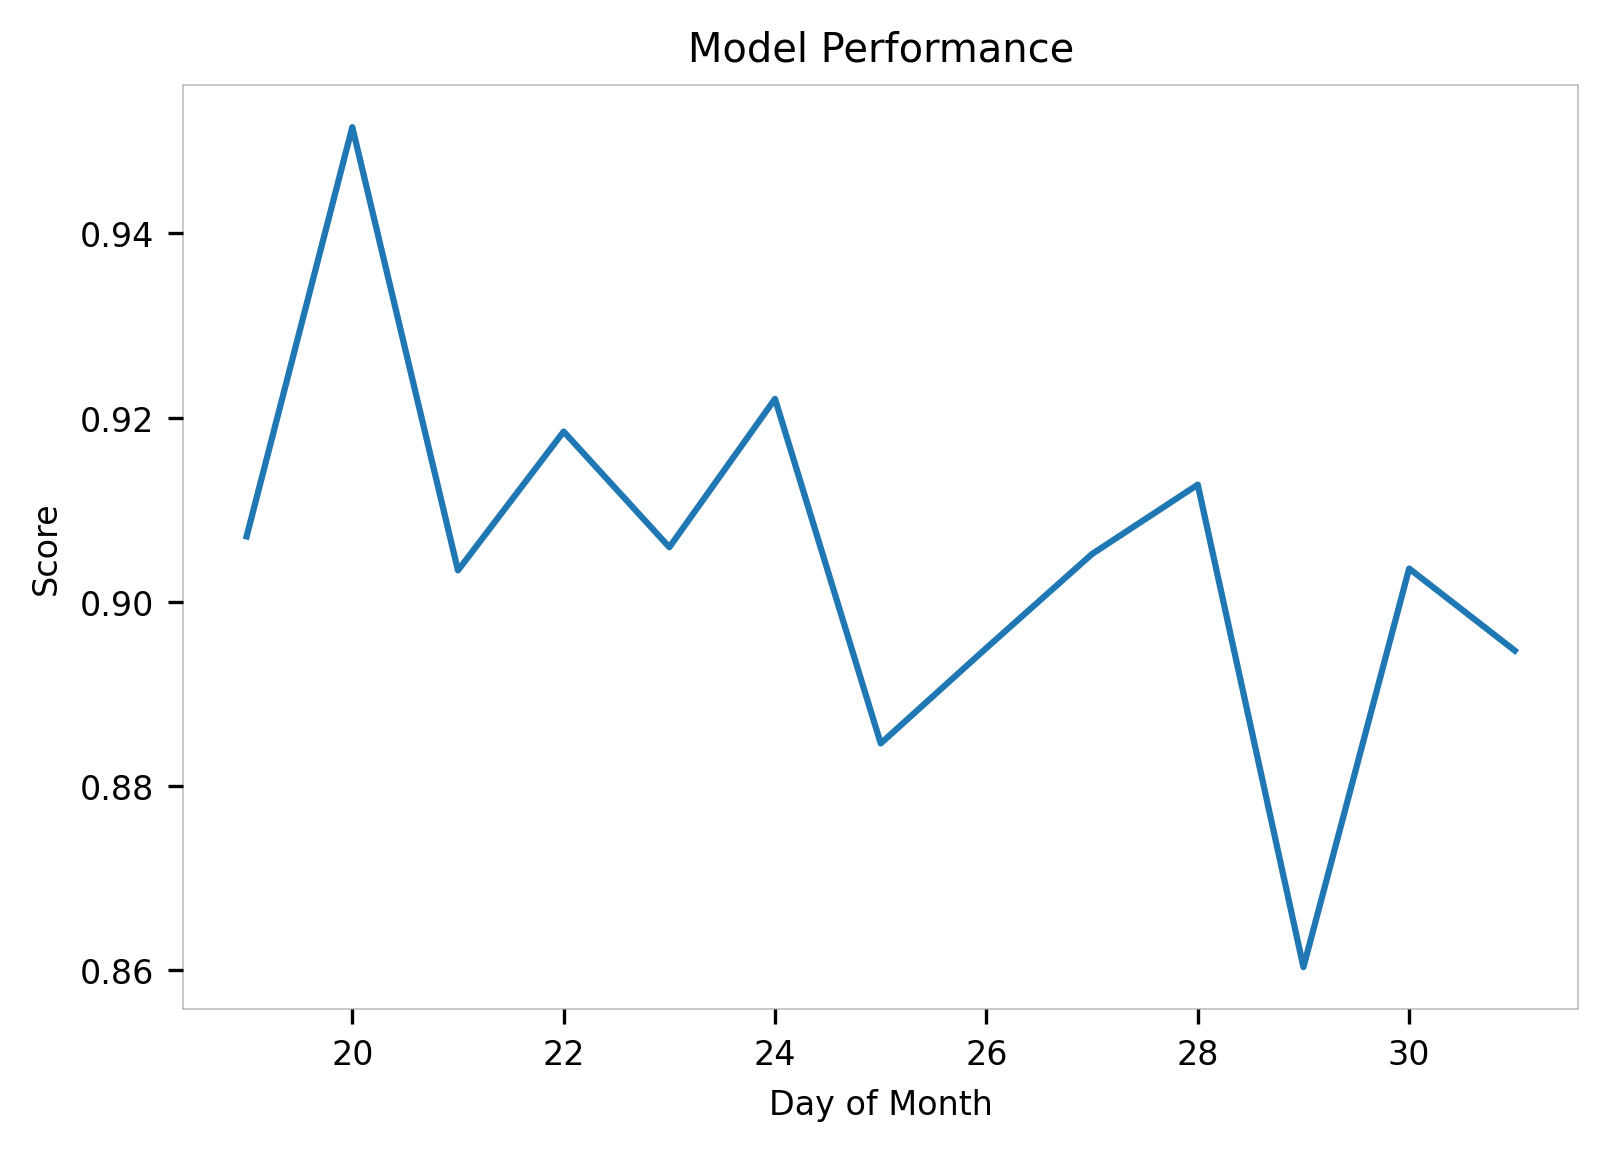

In [21]:
# X_train (day 14-18), y_train (day 19), X_val (day 25-29), y_val (day 30)
model3 = trainTS(ts_to_ds(ts.iloc[:, 13:], 5, 2), plotV=True)

performance(model=model3, ts=ts, start=18)

In [ ]:
# save notebook
display(Javascript('IPython.notebook.save_checkpoint();'))
# save notebook as html to eugpoon.github.io/projects
!jupyter nbconvert  traffic.ipynb --to html
%mv "traffic.html" "../eugpoon.github.io/projects/"
# restyle imports, clear output, replace file
!cleanipynb traffic.ipynb
# restart kernel
display(HTML("<script>Jupyter.notebook.kernel.restart()</script>"))